In [1]:
!pip install -q gdown
!gdown --id 1CmqtHQVI4ElKIzMWMnIFewGJ-no1Dh8S
!unzip imfs_all.zip -d /content/data_npz/

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CmqtHQVI4ElKIzMWMnIFewGJ-no1Dh8S
From (redirected): https://drive.google.com/uc?id=1CmqtHQVI4ElKIzMWMnIFewGJ-no1Dh8S&confirm=t&uuid=be55b302-9bd7-476a-af99-c514ffcb095c
To: /content/imfs_all.zip
100% 1.84G/1.84G [00:25<00:00, 71.3MB/s]
Archive:  imfs_all.zip
  inflating: /content/data_npz/val_imfs.npz  
  inflating: /content/data_npz/test_imfs.npz  
  inflating: /content/data_npz/imfs.npz  


In [2]:
!pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
datasets 4.0.

In [1]:
import os
import math
import zipfile
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
# from PyEMD import EMD
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from multiprocessing import Pool, cpu_count
from scipy.signal import hilbert

from scipy import signal
from scipy.spatial.distance import euclidean

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.utils import resample, gen_batches, compute_class_weight
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, hinge_loss, log_loss
)
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import scipy.stats
from scipy.stats import entropy as scipy_entropy

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

import pickle
import joblib
from joblib import Parallel, delayed
import json

In [ ]:
!git clone https://github.com/EnfangCui/MetroDataset.git

Cloning into 'MetroDataset'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 73 (delta 15), reused 0 (delta 0), pack-reused 19 (from 1)
Receiving objects: 100% (73/73), 87.02 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (9/9), done.


In [ ]:
base_path = '/content/MetroDataset'
failure_path = os.path.join(base_path, 'Failure')
normal_path = os.path.join(base_path, 'Normal')

def extract_zip_files(folder_path):
    for zip_file in os.listdir(folder_path):
        if zip_file.endswith('.zip'):
            folder_name = zip_file.replace('.zip', '')
            if not os.path.exists(os.path.join(folder_path, folder_name)):
                print(f"Extracting {zip_file}...")
                with zipfile.ZipFile(os.path.join(folder_path, zip_file), 'r') as zip_ref:
                    zip_ref.extractall(folder_path)
                print(f"Extraction of {zip_file} complete.")
            else:
                print(f"{folder_name} already exists, skipping extraction.")

extract_zip_files(failure_path)
extract_zip_files(normal_path)

Extracting Metro_vibration_v1_x_axis_failure.zip...
Extraction of Metro_vibration_v1_x_axis_failure.zip complete.
Extracting Metro_vibration_v1_y_axis_failure.zip...
Extraction of Metro_vibration_v1_y_axis_failure.zip complete.
Extracting Metro_vibration_v1_z_axis_failure.zip...
Extraction of Metro_vibration_v1_z_axis_failure.zip complete.
Extracting Metro_vibration_v1_y_axis_normal.zip...
Extraction of Metro_vibration_v1_y_axis_normal.zip complete.
Extracting Metro_vibration_v1_z_axis_normal.zip...
Extraction of Metro_vibration_v1_z_axis_normal.zip complete.
Extracting Metro_vibration_v1_x_axis_normal.zip...
Extraction of Metro_vibration_v1_x_axis_normal.zip complete.


In [ ]:
failure_x_path = os.path.join('/content/MetroDataset/Failure/Metro_vibration_v1_x_axis_failure.csv')
failure_y_path = os.path.join('/content/MetroDataset/Failure/Metro_vibration_v1_y_axis_failure.csv')
failure_z_path = os.path.join('/content/MetroDataset/Failure/Metro_vibration_v1_z_axis_failure.csv')

normal_x_path = os.path.join('/content/MetroDataset/Normal/Metro_vibration_v1_x_axis_normal.csv')
normal_y_path = os.path.join('/content/MetroDataset/Normal/Metro_vibration_v1_y_axis_normal.csv')
normal_z_path = os.path.join('/content/MetroDataset/Normal/Metro_vibration_v1_z_axis_normal.csv')

failure_x = pd.read_csv(failure_x_path, index_col=0)
failure_y = pd.read_csv(failure_y_path, index_col=0)
failure_z = pd.read_csv(failure_z_path, index_col=0)

normal_x = pd.read_csv(normal_x_path, index_col=0)
normal_y = pd.read_csv(normal_y_path, index_col=0)
normal_z = pd.read_csv(normal_z_path, index_col=0)
print(len(failure_x))
print(len(normal_x ))

6231040
3635200


In [ ]:
failure_x.shape,failure_y.shape,failure_z.shape

((6231040, 1), (6231040, 1), (6231040, 1))

In [ ]:
normal_x.shape,normal_y.shape,normal_z.shape

((3635200, 1), (3635200, 1), (3635200, 1))

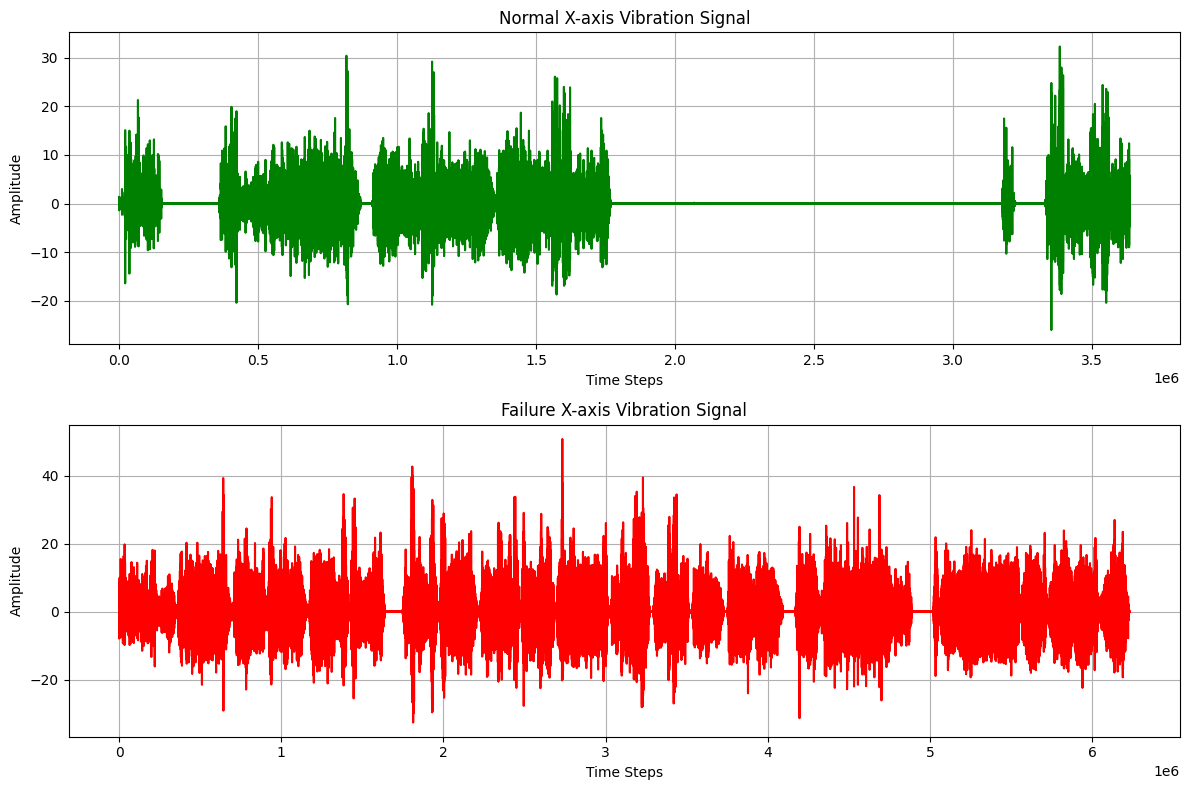

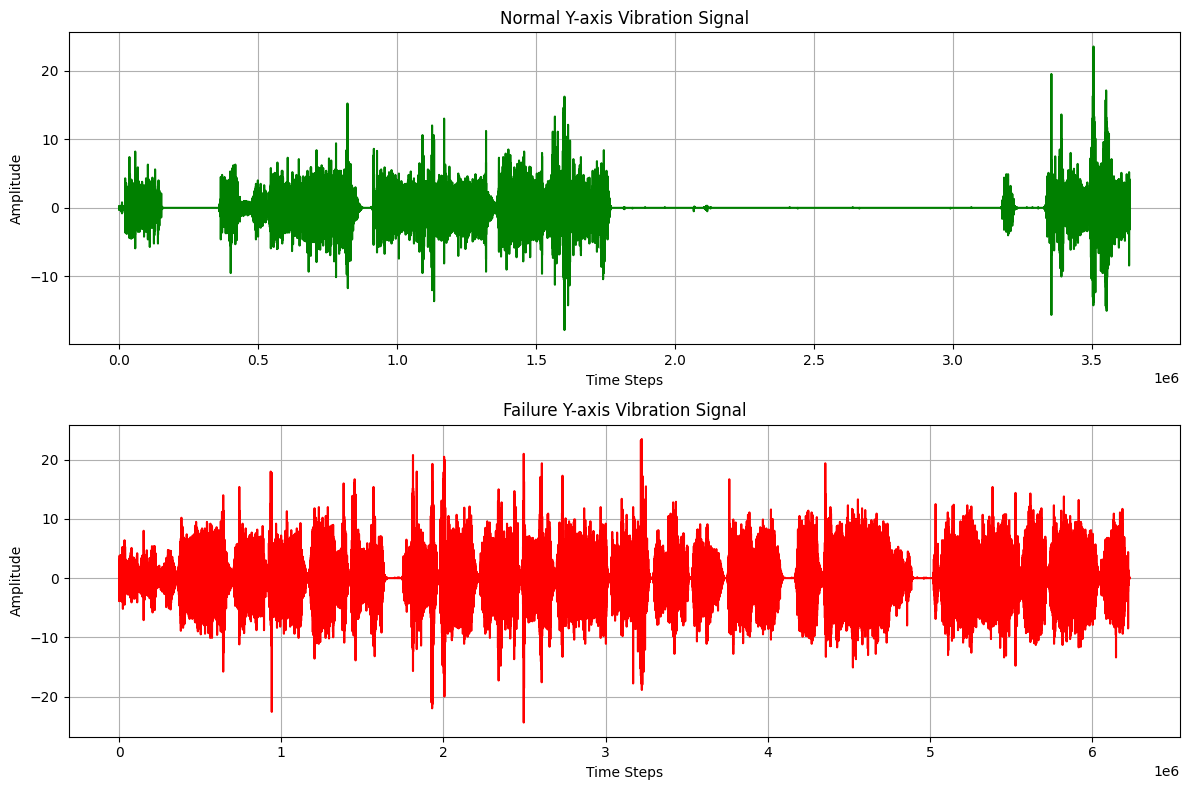

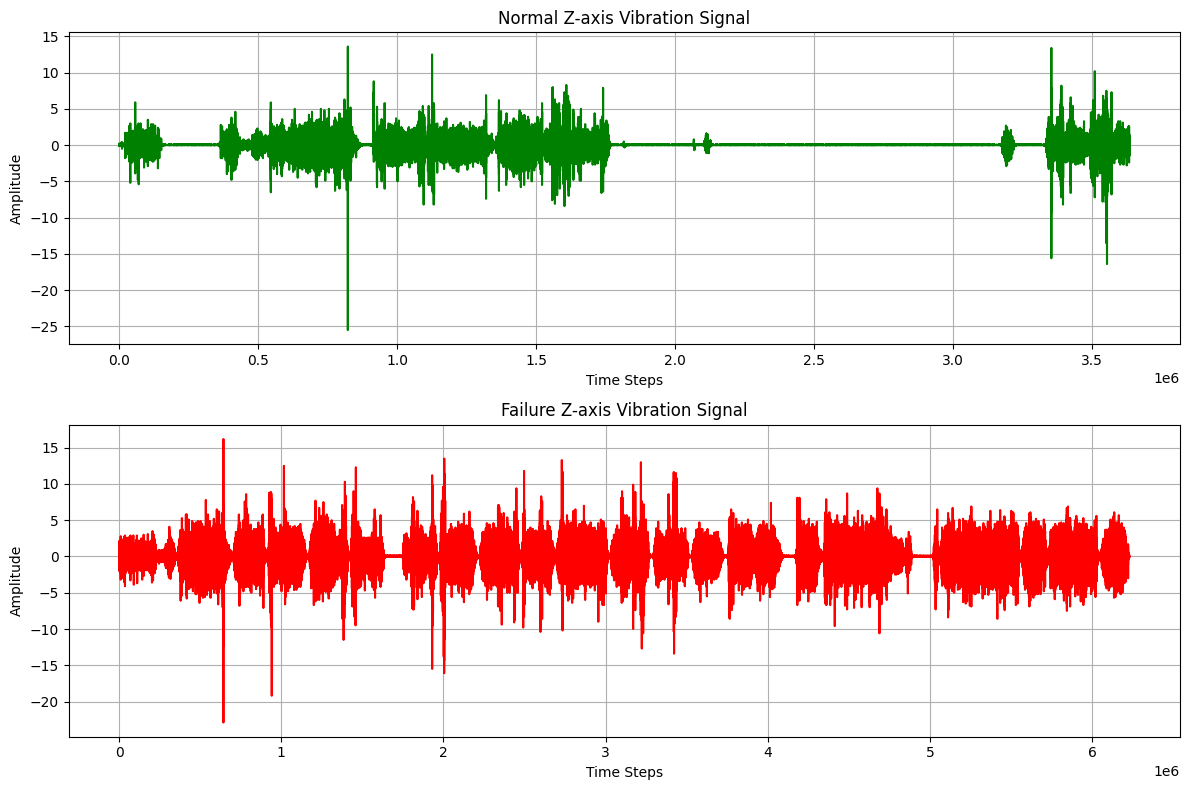

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting Normal X-axis Vibrational Signal
plt.subplot(2, 1, 1)
plt.plot(normal_x.index, normal_x.values, color='green')
plt.title('Normal X-axis Vibration Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

# Plotting Failure X-axis Vibrational Signal
plt.subplot(2, 1, 2)
plt.plot(failure_x.index, failure_x.values, color='red')
plt.title('Failure X-axis Vibration Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

# Plotting Normal Y-axis Vibration Signal
plt.subplot(2, 1, 1)
plt.plot(normal_y.index,normal_y.values, color='green')
plt.title('Normal Y-axis Vibration Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

# Plotting Failure Y-axis Vibration Signal
plt.subplot(2, 1, 2)
plt.plot(failure_y.index,failure_y.values, color='red')
plt.title('Failure Y-axis Vibration Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

# Plotting Normal Z-axis Vibration Signal
plt.subplot(2, 1, 1)
plt.plot(normal_z.index,normal_z.values, color='green')
plt.title('Normal Z-axis Vibration Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

# Plotting Failure Z-axis Vibration Signal
plt.subplot(2, 1, 2)
plt.plot(failure_z.index,failure_z.values, color='red')
plt.title('Failure Z-axis Vibration Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def compute_energy(signal):
    return np.sum(signal[:, 0]**2 + signal[:, 1]**2 + signal[:, 2]**2)

def create_samples(x, y, z, window_size, step_size):

    x = x.values
    y = y.values
    z = z.values
    energies = []
    samples = []
    for start in range(0, len(x) - window_size + 1, step_size):
        end = start + window_size
        signal = np.stack([x[start:end], y[start:end], z[start:end]], axis=1)  # Shape: (1024, 3)
        samples.append(signal)
        energy = compute_energy(signal)
        energies.append(energy)
    return np.array(samples),sorted(energies,reverse = True)


sampling_rate = 1024
step_size = int(sampling_rate / 4)

failure_samples, failure_energies = create_samples(failure_x, failure_y, failure_z, sampling_rate, step_size)
normal_samples, normal_energies = create_samples(normal_x, normal_y, normal_z, sampling_rate, step_size)

In [ ]:
failure_samples.shape,normal_samples.shape

((24337, 1024, 3, 1), (14197, 1024, 3, 1))

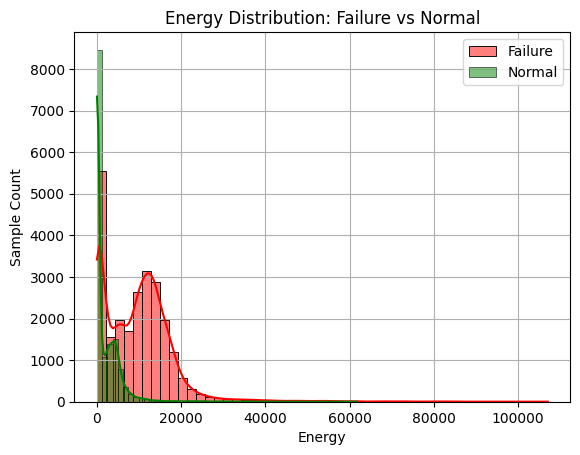

In [ ]:
sns.histplot(failure_energies, bins=50, kde=True, color='red', label='Failure')
sns.histplot(normal_energies, bins=50, kde=True, color='green', label='Normal')
plt.title("Energy Distribution: Failure vs Normal")
plt.xlabel("Energy")
plt.ylabel("Sample Count")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
std_failure_energies = np.std(failure_energies)
std_normal_energies = np.std(normal_energies)

print(f"Standard Deviation of Failure Energies: {std_failure_energies}")
print(f"Standard Deviation of Normal Energies: {std_normal_energies}")


Standard Deviation of Failure Energies: 8760.939621377525
Standard Deviation of Normal Energies: 3600.5887829381622


In [ ]:
print(len(failure_samples))
print(len(normal_samples))

24337
14197


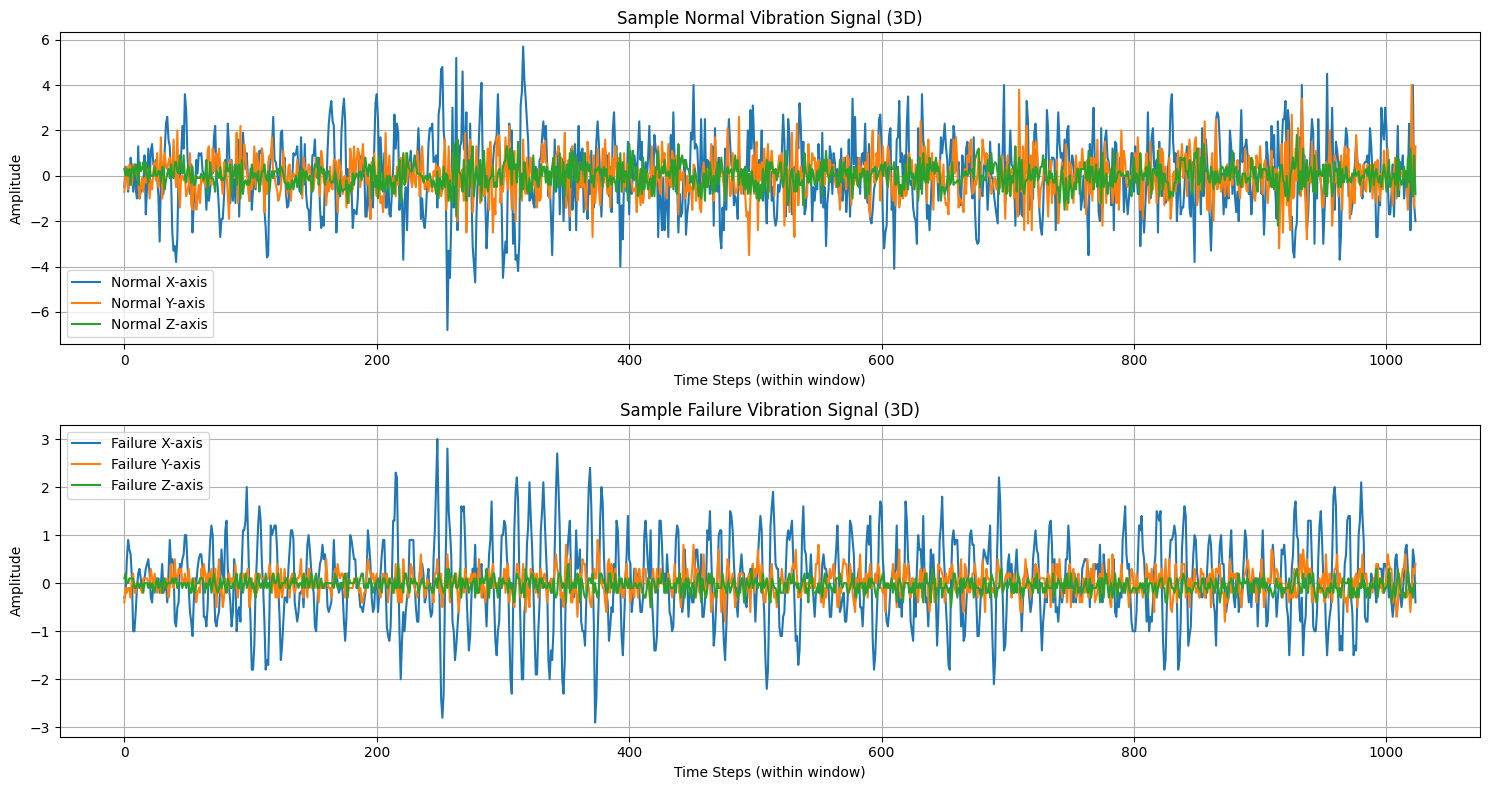

In [ ]:
# Visualising combined x,y,z random samples of normal and failure

sample_failure_3d = failure_samples[np.random.randint(len(failure_samples))]

sample_normal_3d = normal_samples[np.random.randint(len(normal_samples))]

plt.figure(figsize=(15, 8))

# Plotting Normal Sample
plt.subplot(2, 1, 1)
plt.plot(sample_normal_3d[:, 0], label='Normal X-axis')
plt.plot(sample_normal_3d[:, 1], label='Normal Y-axis')
plt.plot(sample_normal_3d[:, 2], label='Normal Z-axis')
plt.title('Sample Normal Vibration Signal (3D)')
plt.xlabel('Time Steps (within window)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plotting Failure Sample
plt.subplot(2, 1, 2)
plt.plot(sample_failure_3d[:, 0], label='Failure X-axis')
plt.plot(sample_failure_3d[:, 1], label='Failure Y-axis')
plt.plot(sample_failure_3d[:, 2], label='Failure Z-axis')
plt.title('Sample Failure Vibration Signal (3D)')
plt.xlabel('Time Steps (within window)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 2. To Handle class imbalance between failure and normal(failure samples >> normal samples) we used strategic downsampling
max_normal_samples = len(normal_samples)
failure_samples = resample(failure_samples,
                          replace=False,
                          n_samples=int(1.5 * max_normal_samples),  # now we made failure and normal samples are in the ratio 1.5:1
                          random_state=42)

In [ ]:
# 3. Create labels : 1 for failure and 0 for normal
failure_labels = np.ones(len(failure_samples))
normal_labels = np.zeros(len(normal_samples))

In [ ]:
def random_split(data, labels):

    # First split: train and temp
    data_train, data_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)


    # Second split: validation and test from temp
    data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)

    return data_train, data_val, data_test, labels_train, labels_val, labels_test

# we Splitted each class separately using randomized split
failure_train, failure_val, failure_test, y_failure_train, y_failure_val, y_failure_test = random_split(failure_samples, failure_labels)
normal_train, normal_val, normal_test, y_normal_train, y_normal_val, y_normal_test = random_split(normal_samples, normal_labels)

# here we combining failurea and normal classes
X_train = np.concatenate([failure_train, normal_train])
X_val = np.concatenate([failure_val, normal_val])
X_test = np.concatenate([failure_test, normal_test])
y_train = np.concatenate([y_failure_train, y_normal_train])
y_val = np.concatenate([y_failure_val, y_normal_val])
y_test = np.concatenate([y_failure_test, y_normal_test])

In [ ]:
# 5. Normalization using training statistics

def normalize_data(train, val, test):

    mean = np.mean(train, axis=(0, 1))  # Mean per train channel across all samples and thier datapoints
    std = np.std(train, axis=(0, 1))

    # now we Normalizing the datasets using that mean and std
    train_norm = (train - mean) / std
    val_norm = (val - mean) / std
    test_norm = (test - mean) / std


    return train_norm, val_norm, test_norm

X_train, X_val, X_test = normalize_data(X_train, X_val, X_test)

In [ ]:
# 6. Final shuffle (preserves temporal order in validation/test)

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = shuffle_in_unison(X_train, y_train)

In [ ]:
X_train_energies = [compute_energy(sample) for sample in X_train]
X_val_energies = [compute_energy(sample) for sample in X_val]
X_test_energies = [compute_energy(sample) for sample in X_test]
std_X_train_energies = np.std(X_train_energies)
std_X_val_energies = np.std(X_val_energies)
std_X_test_energies = np.std(X_test_energies)


print(f"Standard Deviation of Sample Energies (X_train): {std_X_train_energies}")
print(f"Standard Deviation of Sample Energies (X_val): {std_X_val_energies}")
print(f"Standard Deviation of Sample Energies (X_val): {std_X_test_energies}")


Standard Deviation of Sample Energies (X_train): 3499.0183218554007
Standard Deviation of Sample Energies (X_val): 3598.21671236207
Standard Deviation of Sample Energies (X_val): 3495.343781162667


In [3]:
X_train_sample = X_train.squeeze().astype(np.float32)
X_val_sample = X_val.squeeze().astype(np.float32)
X_test_sample = X_test.squeeze().astype(np.float32)

In [14]:
X_train.shape

(24843, 1024, 3, 1)

In [15]:
X_train_sample.shape

(24843, 1024, 3)

In [ ]:
def compute_energy(signal):
    return np.sum(signal[:, 0]**2 + signal[:, 1]**2 + signal[:, 2]**2)

def compute_std(signal):
    return np.std(signal[:, 0]) + np.std(signal[:, 1]) + np.std(signal[:, 2])

def compute_mean(signal):
    return np.mean(signal[:, 0]) + np.mean(signal[:, 1]) + np.mean(signal[:, 2])

def compute_entropy(signal, bins=100):
    entropies = []
    for axis in range(3):
        hist, bin_edges = np.histogram(signal, bins=100, density=True)
        bin_widths = np.diff(bin_edges)
        probabilities = hist * bin_widths+1e-12
        entropy = scipy.stats.entropy(probabilities, base=2)
        entropies.append(entropy)
    return np.sum(entropies)

def compute_zcr(signal):
    zcr_total = 0
    for axis in range(3):
        zcr_total += np.sum(signal[:-1] * signal[1:] < 0)
    return zcr_total

def compute_rms(signal):
    return np.sqrt(np.mean(signal[:, 0]**2) + np.mean(signal[:, 1]**2) + np.mean(signal[:, 2]**2))

def compute_crest_factor(signal):
    rms = compute_rms(signal)
    peak = max(np.max(np.abs(signal[:, 0])), np.max(np.abs(signal[:, 1])), np.max(np.abs(signal[:, 2])))
    return peak / (rms + 1e-8)  # Avoid divide-by-zero

def compute_p2p(signal):
    return (np.ptp(signal[:, 0]) + np.ptp(signal[:, 1]) + np.ptp(signal[:, 2]))

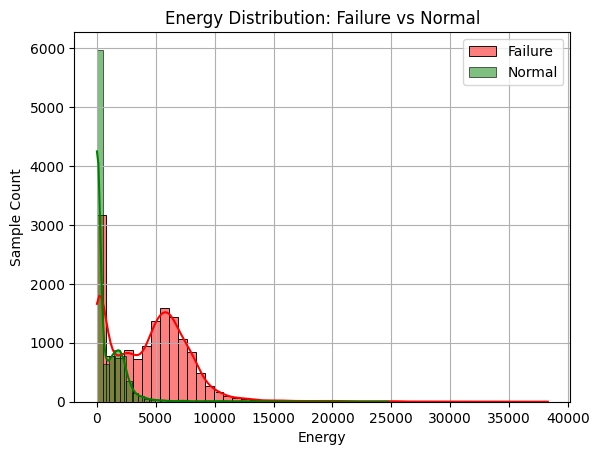

In [ ]:
failure_energies = [compute_energy(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_energies = [compute_energy(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]
sns.histplot(failure_energies, bins=50, kde=True, color='red', label='Failure')
sns.histplot(normal_energies, bins=50, kde=True, color='green', label='Normal')
plt.title("Energy Distribution: Failure vs Normal")
plt.xlabel("Energy")
plt.ylabel("Sample Count")
plt.legend()
plt.grid(True)
plt.show()

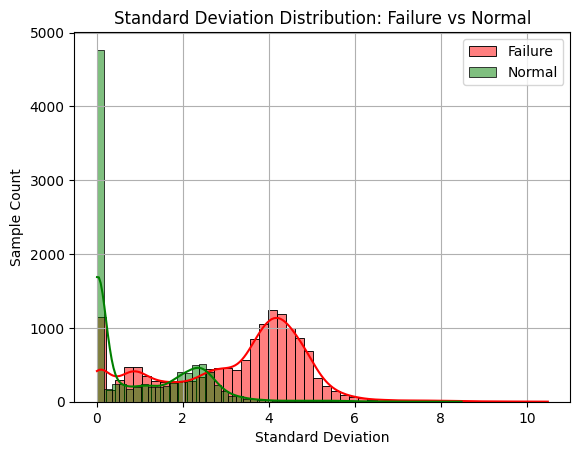

In [ ]:
failure_stdev = [compute_std(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_stdev = [compute_std(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]

sns.histplot(failure_stdev, bins=50, kde=True, color='red', label='Failure')
sns.histplot(normal_stdev, bins=50, kde=True, color='green', label='Normal')
plt.title("Standard Deviation Distribution: Failure vs Normal")
plt.xlabel("Standard Deviation")
plt.ylabel("Sample Count")
plt.legend()
plt.grid(True)
plt.show()

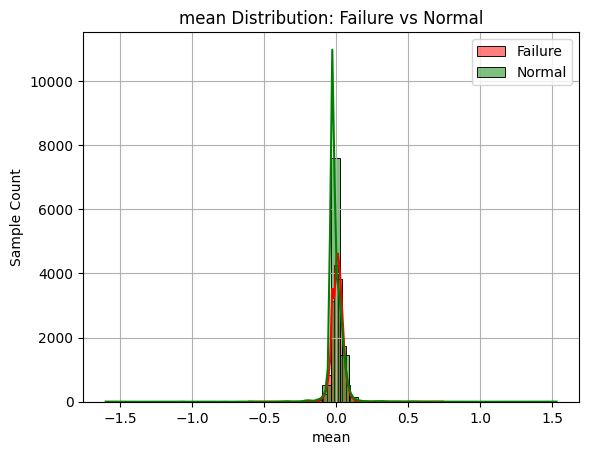

In [ ]:
failure_means = [compute_mean(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_means = [compute_mean(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]

sns.histplot(failure_means, bins=50, kde=True, color='red', label='Failure')
sns.histplot(normal_means, bins=50, kde=True, color='green', label='Normal')
plt.title("mean Distribution: Failure vs Normal")
plt.xlabel("mean")
plt.ylabel("Sample Count")
plt.legend()
plt.grid(True)
plt.show()

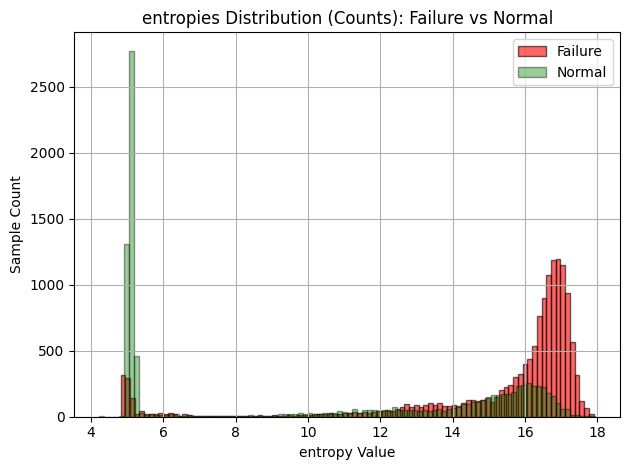

In [ ]:
failure_entropies = [compute_entropy(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_entropies = [compute_entropy(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]

plt.hist(failure_entropies, bins=100, alpha=0.6, color='red', label='Failure', edgecolor='black')
plt.hist(normal_entropies, bins=100, alpha=0.4, color='green', label='Normal', edgecolor='black')
plt.title('entropies Distribution (Counts): Failure vs Normal')
plt.xlabel('entropy Value')
plt.ylabel('Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

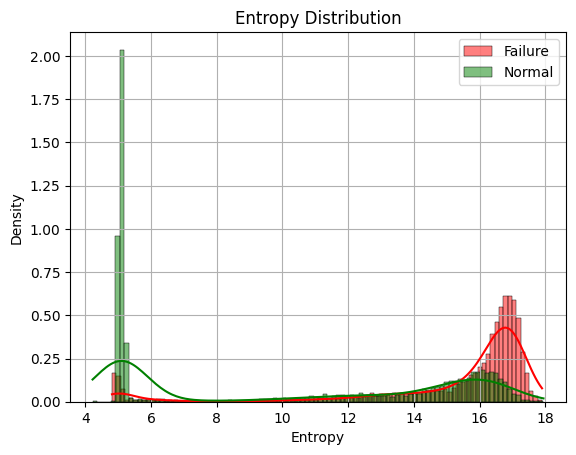

In [ ]:
sns.histplot(failure_entropies, bins=100, color='red', kde=True, label='Failure', stat='density')
sns.histplot(normal_entropies, bins=100, color='green', kde=True, label='Normal', stat='density')
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

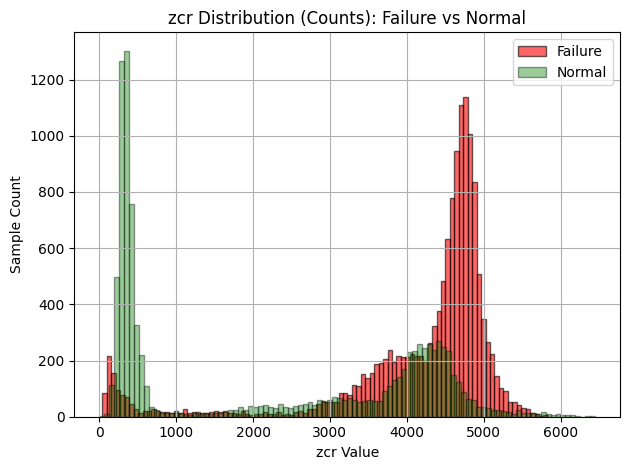

In [ ]:
failure_zcr = [compute_zcr(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_zcr = [compute_zcr(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]

plt.hist(failure_zcr, bins=100, alpha=0.6, color='red', label='Failure', edgecolor='black')
plt.hist(normal_zcr, bins=100, alpha=0.4, color='green', label='Normal', edgecolor='black')
plt.title('zcr Distribution (Counts): Failure vs Normal')
plt.xlabel('zcr Value')
plt.ylabel('Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

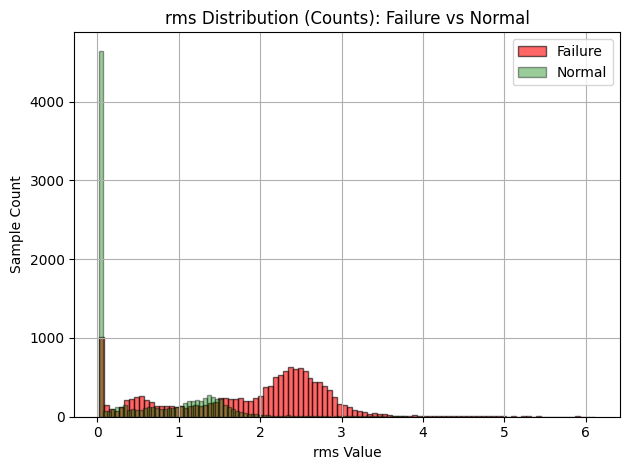

In [ ]:
failure_rms = [compute_rms(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_rms = [compute_rms(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]

plt.hist(failure_rms, bins=100, alpha=0.6, color='red', label='Failure', edgecolor='black')
plt.hist(normal_rms, bins=100, alpha=0.4, color='green', label='Normal', edgecolor='black')
plt.title('rms Distribution (Counts): Failure vs Normal')
plt.xlabel('rms Value')
plt.ylabel('Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

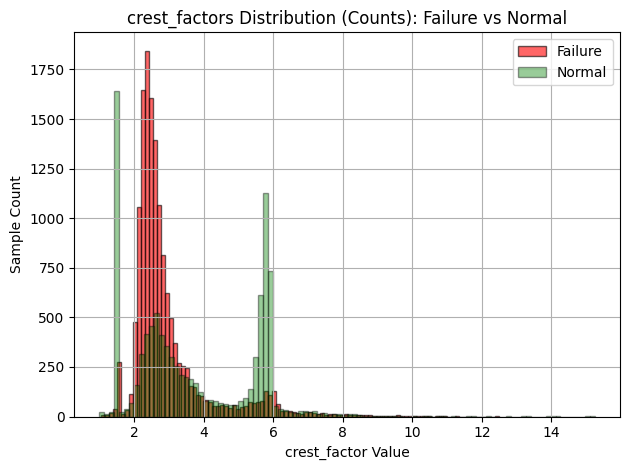

In [ ]:
failure_crest_factors = [compute_crest_factor(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_crest_factors = [compute_crest_factor(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]

plt.hist(failure_crest_factors, bins=100, alpha=0.6, color='red', label='Failure', edgecolor='black')
plt.hist(normal_crest_factors, bins=100, alpha=0.4, color='green', label='Normal', edgecolor='black')
plt.title('crest_factors Distribution (Counts): Failure vs Normal')
plt.xlabel('crest_factor Value')
plt.ylabel('Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

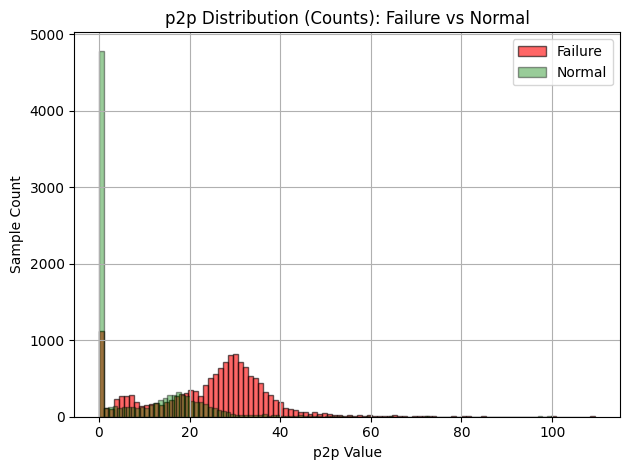

In [ ]:
failure_p2p = [compute_p2p(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 1]
normal_p2p = [compute_p2p(X_train_sample[i]) for i in range(len(X_train)) if y_train[i] == 0]

plt.hist(failure_p2p, bins=100, alpha=0.6, color='red', label='Failure', edgecolor='black')
plt.hist(normal_p2p, bins=100, alpha=0.4, color='green', label='Normal', edgecolor='black')
plt.title('p2p Distribution (Counts): Failure vs Normal')
plt.xlabel('p2p Value')
plt.ylabel('Sample Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Shape of X_train: (24843, 1024, 3, 1)


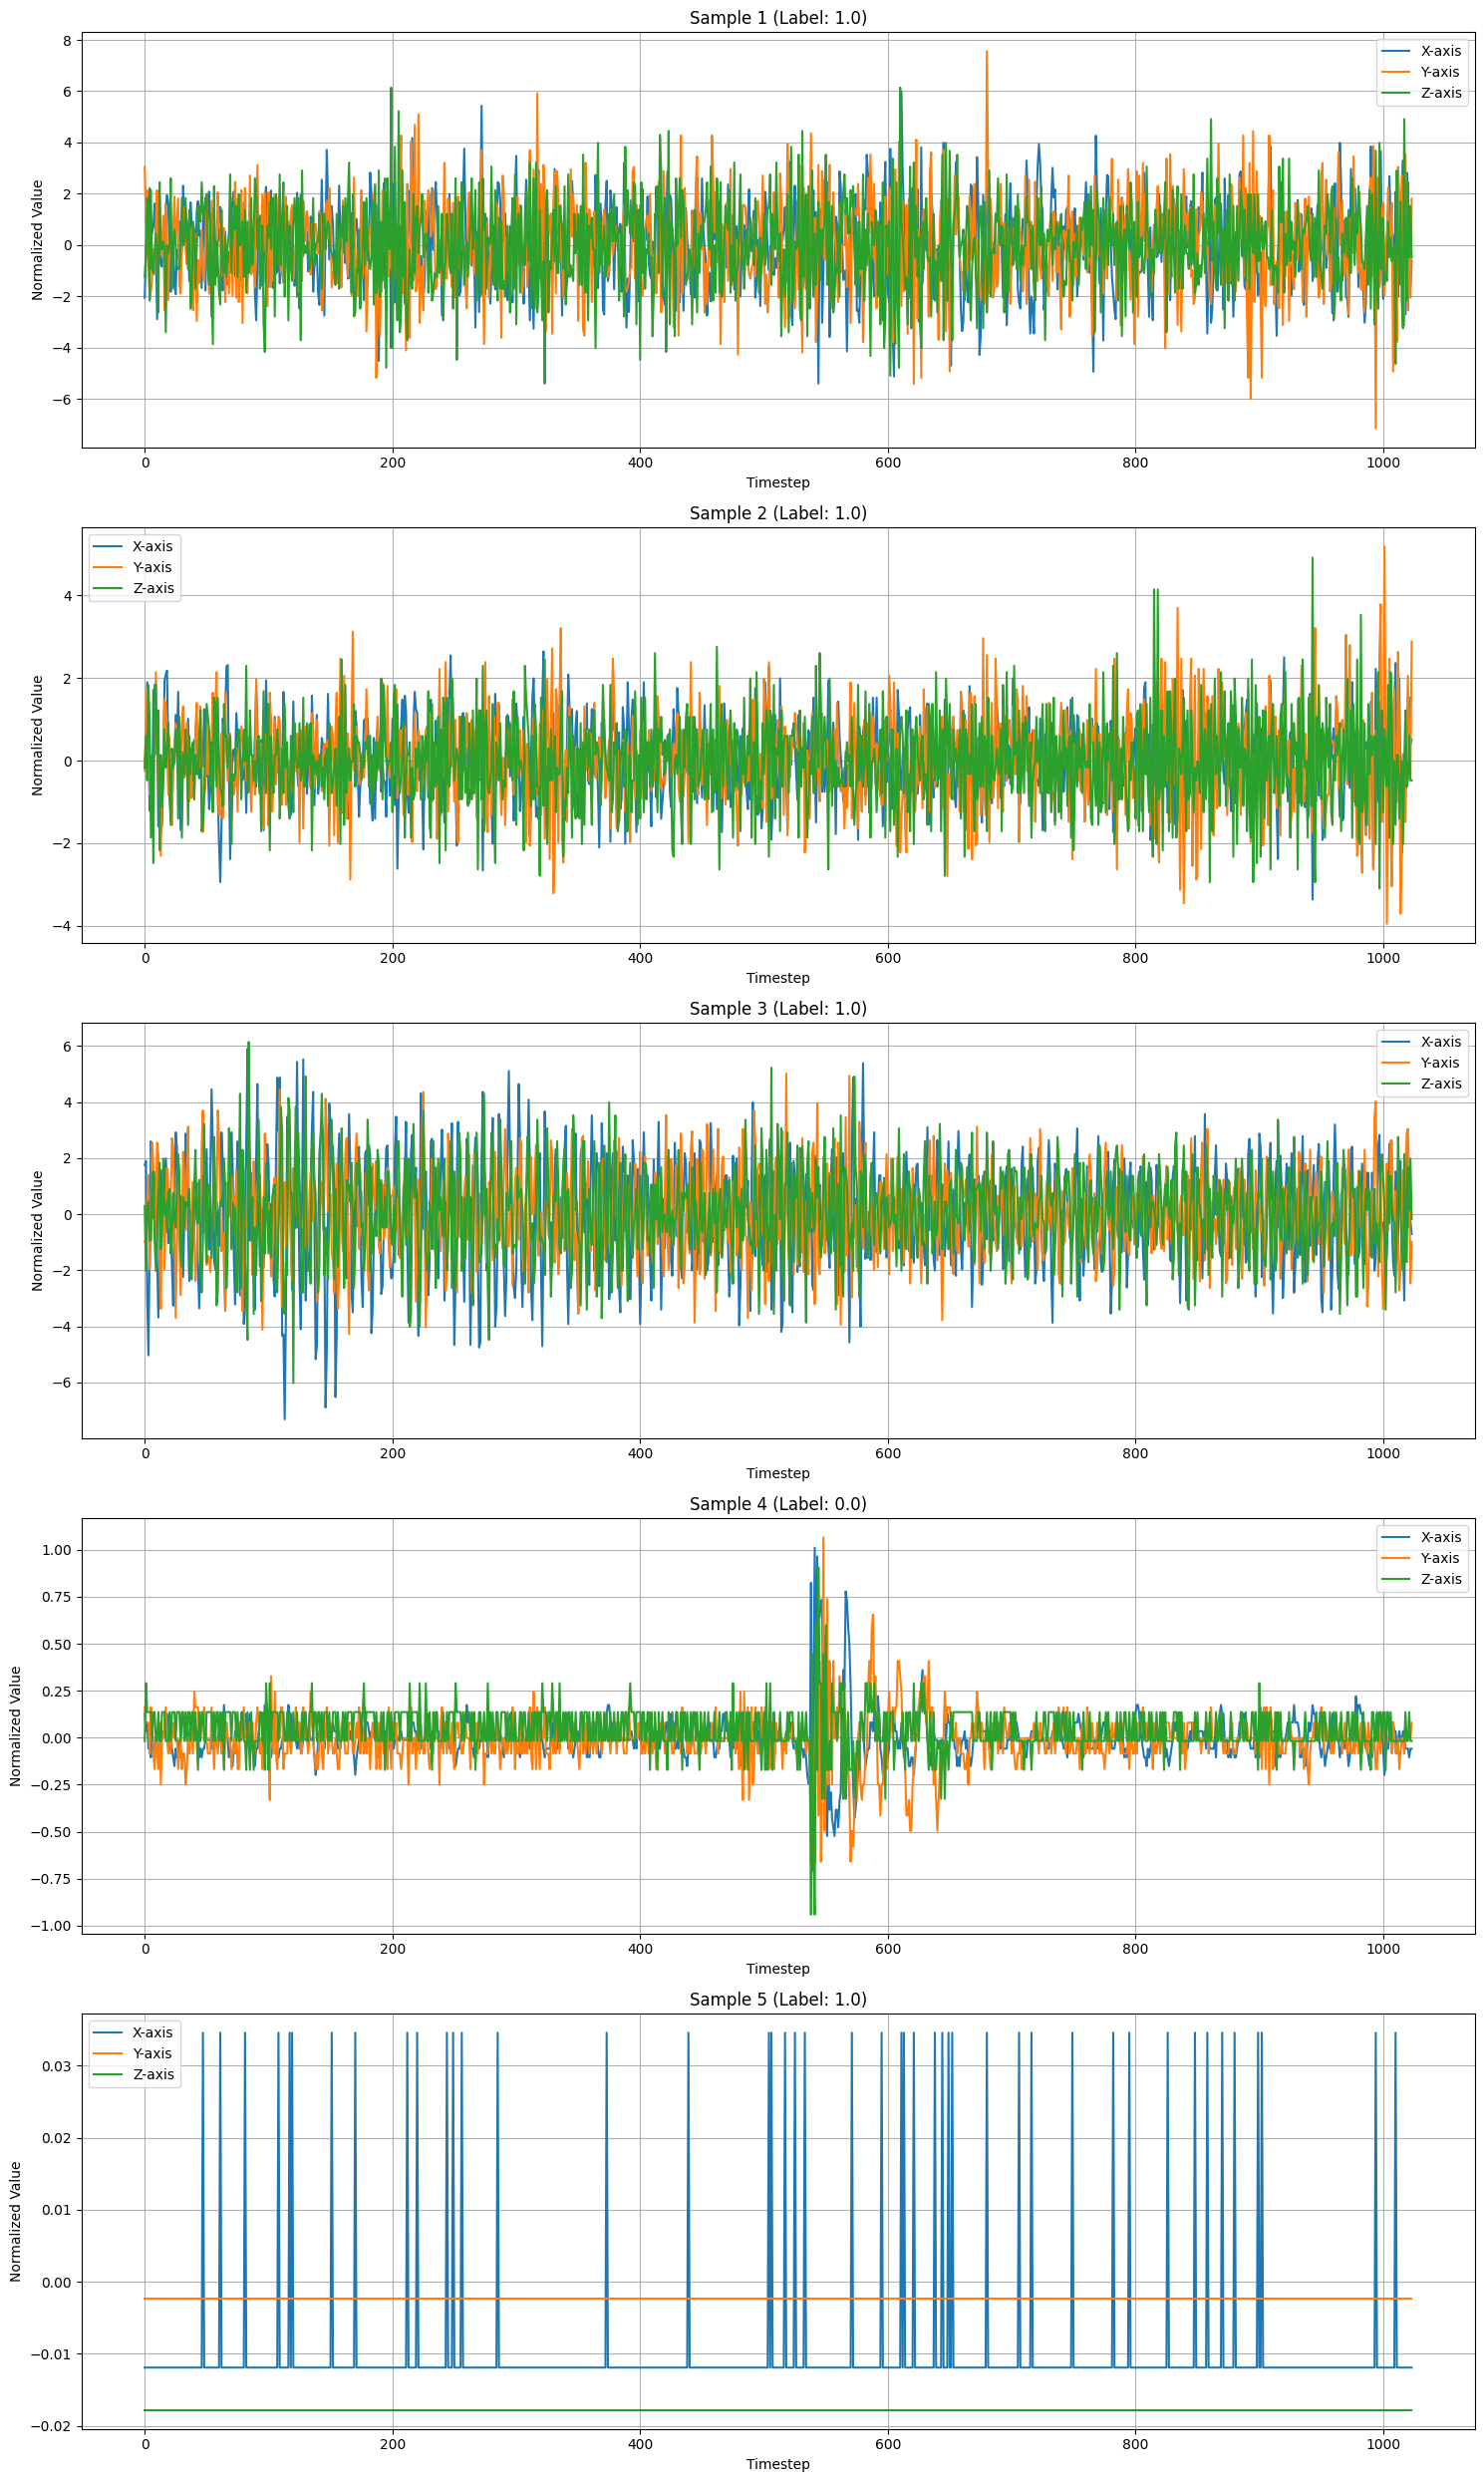

In [ ]:
print("Shape of X_train:", X_train.shape)

# Number of samples to visualize
num_samples_to_plot = 5

plt.figure(figsize=(15, 5 * num_samples_to_plot))

for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(X_train[i, :, 0], label='X-axis')
    plt.plot(X_train[i, :, 1], label='Y-axis')
    plt.plot(X_train[i, :, 2], label='Z-axis')
    plt.title(f'Sample {i+1} (Label: {y_train[i]})')
    plt.xlabel('Timestep')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Saving the preprocessed data
np.savez_compressed('metro_vibration_preprocessed.npz',
                   X_train=X_train, X_val=X_val, X_test=X_test,
                   y_train=y_train, y_val=y_val, y_test=y_test)

In [2]:
data = np.load('metro_vibration_preprocessed.npz')
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

In [12]:
X_train.shape

(24843, 1024, 3, 1)

Number of components (IMFs + residue): 8


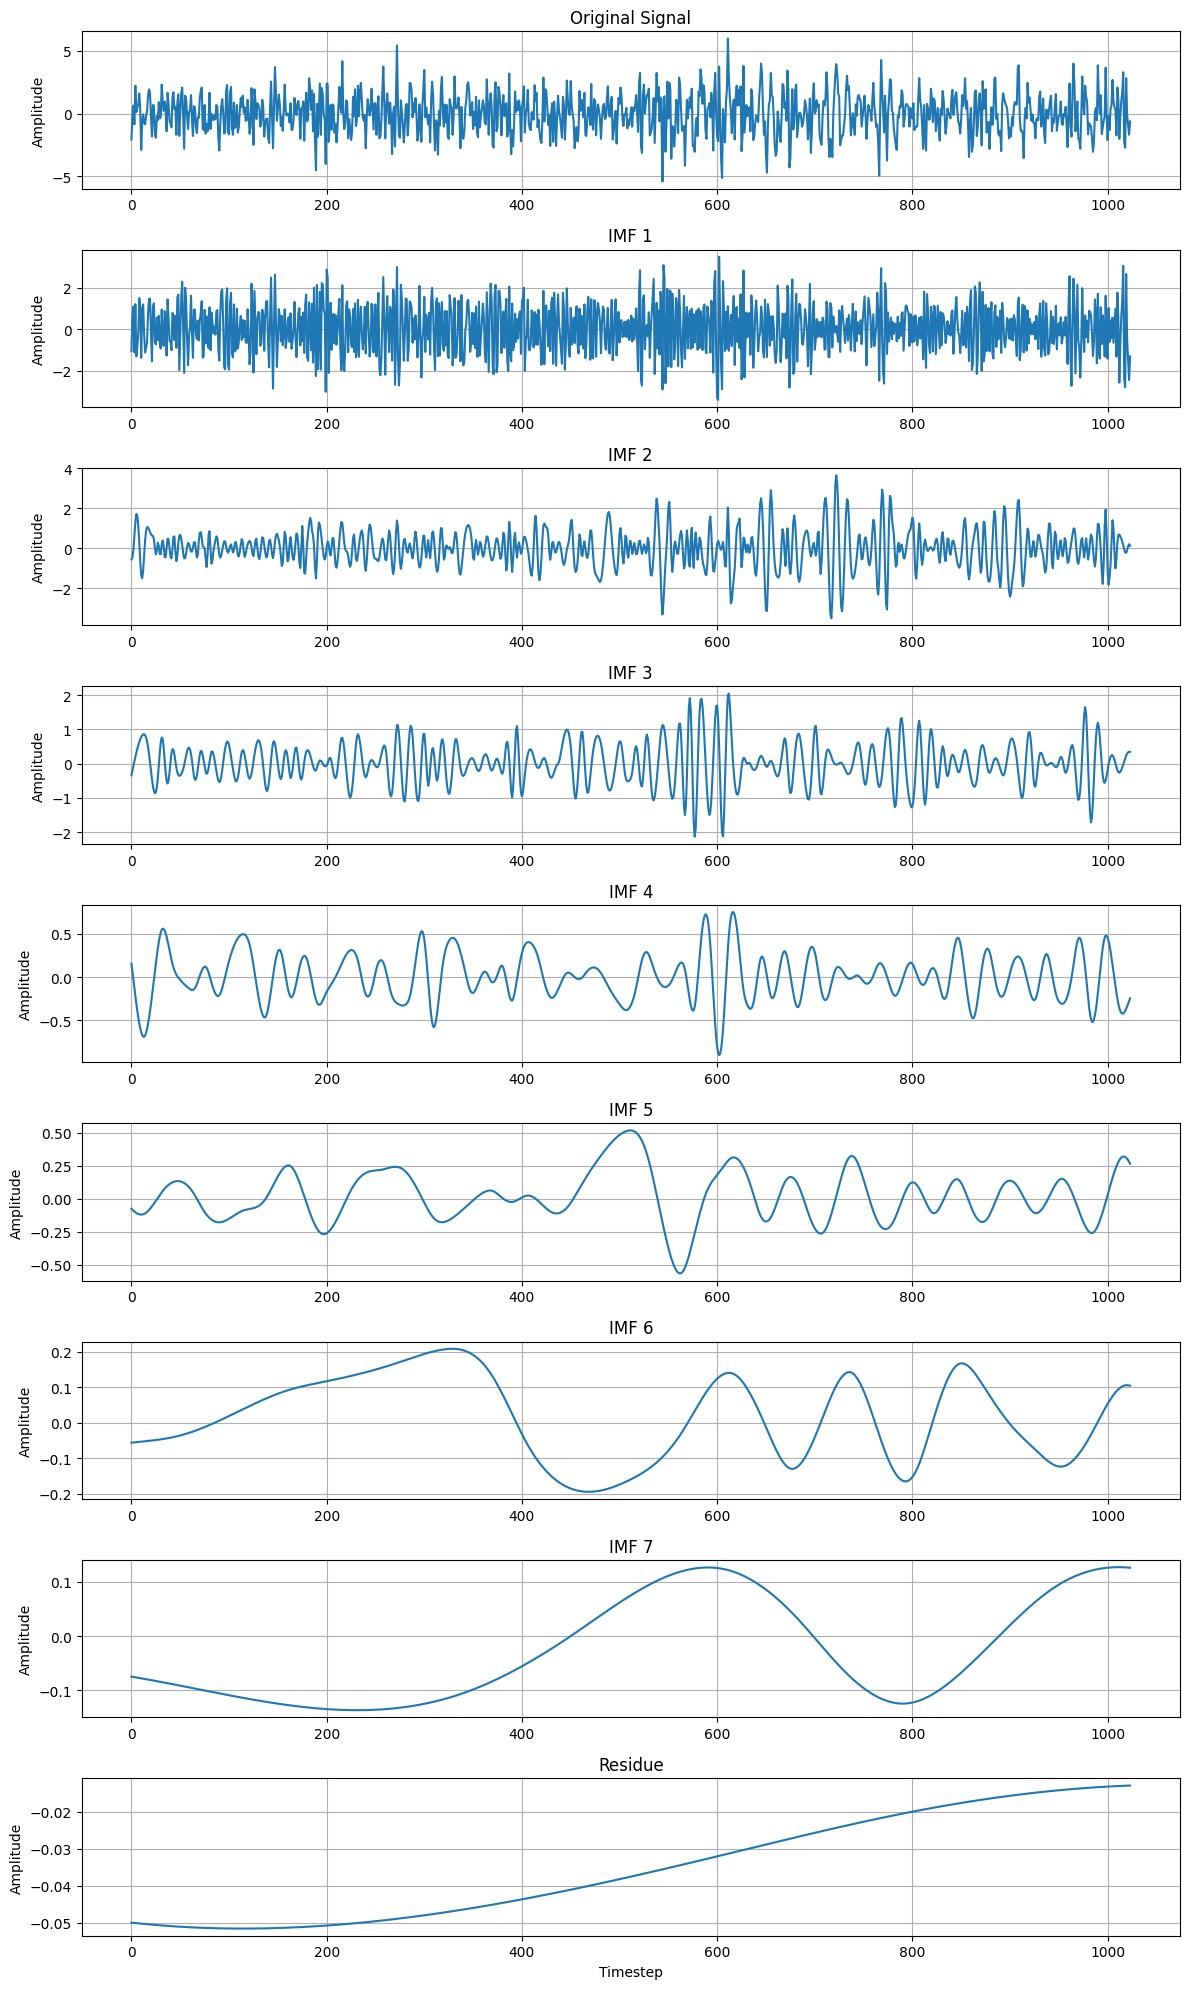

Shape of IMFs array: (8, 1024)
Shape of IMF 1: (1024,)
Shape of IMF 2: (1024,)
Shape of IMF 3: (1024,)
Shape of IMF 4: (1024,)
Shape of IMF 5: (1024,)
Shape of IMF 6: (1024,)
Shape of IMF 7: (1024,)
Shape of IMF 8: (1024,)


In [ ]:
# implementing EMD for one sample signal

sample_signal = X_train_sample[0, :, 0]

# Initialize EMD object
emd = EMD()

# Perform EMD on the selected signal
IMFs = emd(sample_signal)

# IMFs is a list of numpy arrays, where each array is an IMF.

# The last element is the residue.
print(f"Number of components (IMFs + residue): {len(IMFs)}")

# Plotting the original signal and then IMFs are extracted
plt.figure(figsize=(12, 2 * len(IMFs)+4))
plt.subplot(len(IMFs) + 1, 1, 1)
plt.plot(sample_signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.grid(True)

for n, imf in enumerate(IMFs):
    plt.subplot(len(IMFs) + 1, 1, n + 2)
    plt.plot(imf)
    if n < len(IMFs) - 1:
        plt.title(f'IMF {n+1}')
    else:
        plt.title('Residue')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.xlabel('Timestep')
plt.tight_layout()
plt.show()

print(f"Shape of IMFs array: {IMFs.shape}")
for i, imf in enumerate(IMFs):
    print(f"Shape of IMF {i+1}: {imf.shape}")

In [ ]:
def emd_all_samples(X, max_imfs=5):
    n_samples, timesteps, n_axes = X.shape
    imfs_array = np.zeros((n_samples, max_imfs, timesteps, n_axes))

    for axis in range(n_axes):
        print(f"Processing axis {axis+1}/{n_axes}")
        for i in tqdm(range(n_samples), desc=f"Samples"):

            signal = X[i, :, axis]

            emd = EMD()
            imfs = emd(signal)

            if imfs.shape[0] >= max_imfs:
                imfs_array[i, :, :, axis] = imfs[:max_imfs]
            else:
                imfs_array[i, :imfs.shape[0], :, axis] = imfs

    return imfs_array


In [ ]:
# imfs = emd_all_samples(X_train_sample[:1,:,:], max_imfs=5)

In [ ]:
# np.savez_compressed('imfs.npz', imfs=imfs)

In [ ]:
# imfs = np.load('imfs.npz')['imfs']

In [2]:
imfs = np.load('/content/data_npz/imfs.npz')['imfs']

In [ ]:
imfs.shape

(24843, 5, 1024, 3)

In [4]:
val_imfs = np.load('/content/data_npz/val_imfs.npz')['val_imfs']
test_imfs = np.load('/content/data_npz/test_imfs.npz')['test_imfs']

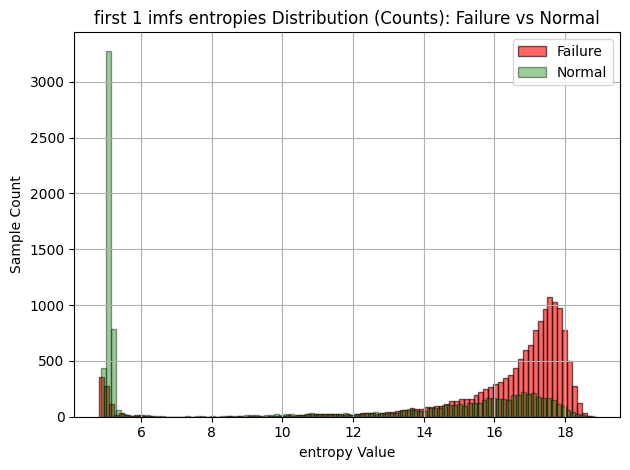

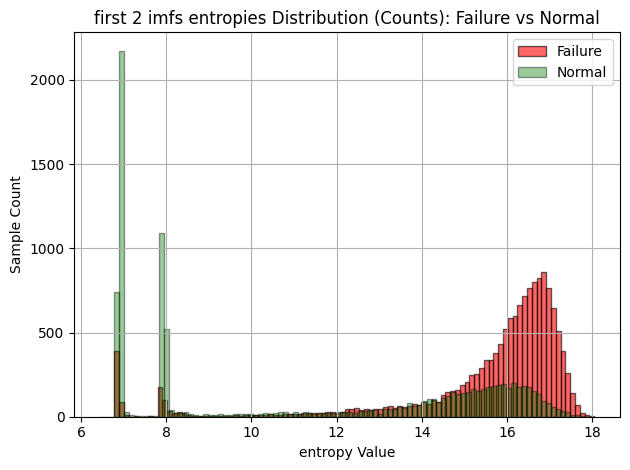

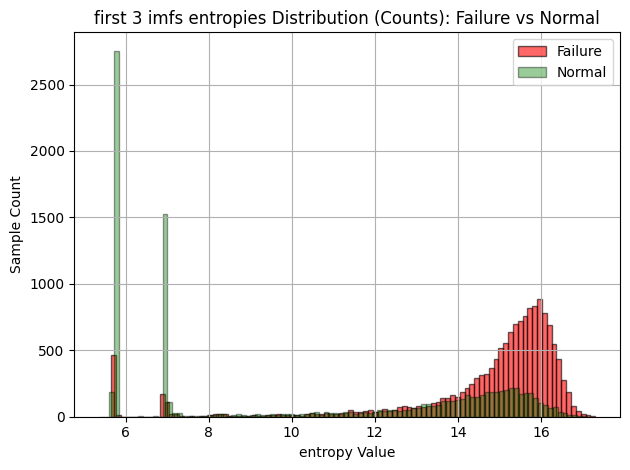

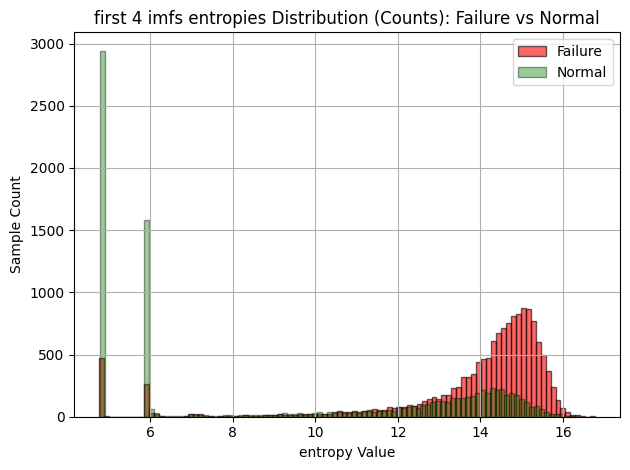

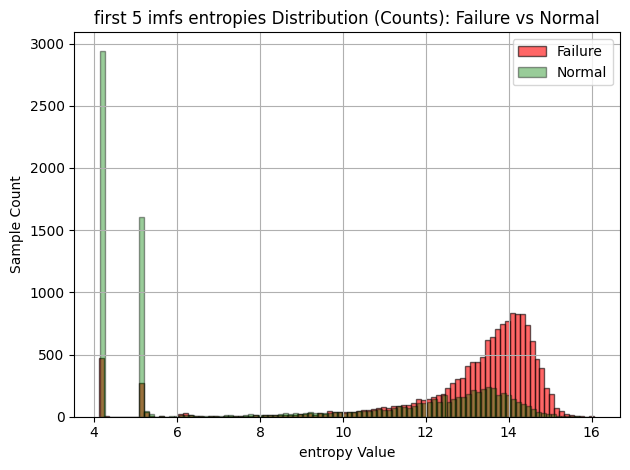

In [ ]:
for imf in range(1,6):
  failure_entropies = [compute_entropy(imfs[:, :imf, :, :][i]) for i in range(24843) if y_train[i] == 1]
  normal_entropies = [compute_entropy(imfs[:, :imf, :, :][i]) for i in range(24843) if y_train[i] == 0]

  plt.hist(failure_entropies, bins=100, alpha=0.6, color='red', label='Failure', edgecolor='black')
  plt.hist(normal_entropies, bins=100, alpha=0.4, color='green', label='Normal', edgecolor='black')
  plt.title('entropies Distribution (Counts): Failure vs Normal')
  plt.xlabel('entropy Value')
  plt.ylabel('Sample Count')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [5]:
def extract_raw_signal_stats(signal):
    features = []
    for axis in range(3):  # x, y, z
        sig = signal[:, axis]

        energy = np.sum(sig**2)
        std = np.std(sig)
        rms = np.sqrt(np.mean(sig**2))
        hist, bin_edges = np.histogram(sig, bins=100, density=True)
        bin_widths = np.diff(bin_edges)
        probabilities = hist * bin_widths+1e-12
        entropy = scipy.stats.entropy(probabilities, base=2)
        zcr = np.sum(sig[:-1] * sig[1:] < 0)
        crest_factor = np.max(np.abs(sig)) / (rms + 1e-8)
        peak2peak = np.ptp(sig)

        features+=[energy, std, rms, entropy, zcr, crest_factor, peak2peak]

    return np.array(features)

In [6]:
def extract_imfs_stats(signal):
    features = []
    for imf in signal:
      for axis in range(3):  # x, y, z
          sig = imf[:, axis]

          energy = np.sum(sig**2)
          std = np.std(sig)
          rms = np.sqrt(np.mean(sig**2))
          hist, bin_edges = np.histogram(sig, bins=100, density=True)
          bin_widths = np.diff(bin_edges)
          probabilities = hist * bin_widths+1e-12
          entropy = scipy.stats.entropy(probabilities, base=2)
          zcr = np.sum(sig[:-1] * sig[1:] < 0)
          crest_factor = np.max(np.abs(sig)) / (rms + 1e-8)
          peak2peak = np.ptp(sig)

          features+=[energy, std, rms, entropy, zcr, crest_factor, peak2peak]
    return np.array(features)

In [7]:
def get_fast_keypoints(img, n_keypoints=25):
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(img, None)
    keypoints = sorted(keypoints, key=lambda x: -x.response)[:n_keypoints]
    return keypoints

In [8]:
def extract_fast_sift_features(samples, n_keypoints=25):
    sift = cv2.SIFT_create()
    all_descriptors = []

    for sample_images in tqdm(samples, desc="Extracting FAST+SIFT Features"):
        sample_descriptors = []

        for img in sample_images:

            kp = get_fast_keypoints(img, n_keypoints)
            _, descriptors = sift.compute(img, kp)

            if descriptors is not None and len(descriptors) > 0:
                sample_descriptors.append(descriptors)

        # Concatenate descriptors from all images in the sample
        if sample_descriptors:
            all_descriptors.append(np.vstack(sample_descriptors))
        else:
            all_descriptors.append(np.zeros((1, 128), dtype=np.float32))  # No valid keypoints in any image

    return all_descriptors


In [9]:
def raw_signals_to_images(raw_signals):
    all_images = []

    for sample in tqdm(raw_signals, desc="Converting each IMF-Axis to individual images"):
        sample_images = []
        for axis in range(3):  # iterate over x, y, z axes
            signal_1d = sample[:, axis]  # shape: (1024,)

            # Normalize to [0,1] and reshape to 32x32 image
            normalized = (signal_1d - np.min(signal_1d)) / (np.ptp(signal_1d) + 1e-8)

            image_normalized = normalized.reshape(32, 32).astype(np.float32)

            image_2d = (image_normalized * 255).astype(np.uint8)

            sample_images.append(image_2d)  # Each shape: (32, 32)

        all_images.append(np.array(sample_images))  # List of 15 images per sample

    return np.array(all_images)  # Final shape: (n_samples, 15, 32, 32)

In [ ]:
a = np.random.randint(0,10,size = (1,1024,3)).astype(np.float32)

In [ ]:
b = raw_signals_to_images(a)

Converting each IMF-Axis to individual images: 100%|██████████| 1/1 [00:00<00:00, 1908.24it/s]


In [ ]:
b.shape

(1, 3, 32, 32)

In [ ]:
b[0].shape

(3, 32, 32)

In [ ]:
b[0][0].shape

(32, 32)

array([[113, 113, 170, ..., 226,  85,  56],
       [198,  56,  85, ..., 141, 141, 113],
       [198,  56, 113, ..., 113,  28, 226],
       ...,
       [ 28, 141, 141, ...,  28,  85,   0],
       [198,   0, 113, ...,  28,  56,   0],
       [226,  85,  85, ..., 226, 141,  28]], dtype=uint8)
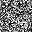

In [ ]:
b[0][0]

In [16]:
# Process Feature Set raw signal
print("\nProcessing Feature Set raw:")

images_raw = raw_signals_to_images(X_train_sample)
descriptors_raw_images = extract_fast_sift_features(images_raw)

np.save('images_raw_train.npy',images_raw)

with open('descriptors_images_raw.pkl', 'wb') as f:
    pickle.dump(descriptors_raw_images, f)


Processing Feature Set raw:


Extracting FAST+SIFT Features: 100%|██████████| 24843/24843 [01:42<00:00, 242.71it/s]


In [ ]:
a = np.concatenate(descriptors_raw_images,axis = 0)

In [ ]:
descriptors_raw_images[0].shape

(75, 128)

In [ ]:
a.shape

(2051343, 128)

In [ ]:
images_raw.shape

(24843, 3, 32, 32)

In [ ]:
images_raw[0]

array([[[ 74, 116, 135, ..., 112, 115, 172],
        [143, 125, 142, ..., 154, 110,  81],
        [134, 132,  97, ..., 146, 122,  85],
        ...,
        [112, 109, 151, ..., 133,  99,  61],
        [131, 174,  98, ..., 109, 207, 147],
        [120, 154,  84, ..., 100,  83, 107]],

       [[176, 138, 160, ...,  91, 123, 123],
        [149, 121, 111, ..., 138, 102, 128],
        [135,  85, 116, ..., 103, 121, 158],
        ...,
        [ 94, 152, 142, ...,  92,  96, 132],
        [149, 125, 115, ..., 160, 169, 102],
        [190, 143,   0, ..., 125,  88, 155]],

       [[ 91, 112, 159, ..., 119, 159, 119],
        [122, 159, 129, ...,  68, 149, 101],
        [ 95, 125,  91, ...,  81, 101, 136],
        ...,
        [122,  91, 125, ..., 112, 163, 170],
        [ 54,  68, 142, ..., 166,  64, 163],
        [129,  50, 200, ..., 108, 153, 108]]], dtype=uint8)

In [ ]:
def plot_images(images, title="Images"):

    num_samples = len(images)
    images_per_sample = images[0].shape[0] if len(images) > 0 else 0
    total_images_to_plot = min(num_samples, 5) * images_per_sample

    # grid size
    cols = images_per_sample
    rows = min(num_samples, 5)

    plt.figure(figsize=(15, 3 * rows))
    plt.suptitle(title, y=1.02)

    for i in range(min(num_samples, 5)):
        for j in range(images_per_sample):
            plt.subplot(rows, cols, i * cols + j + 1)
            plt.imshow(images[i][j], cmap='gray')
            plt.title(f'S-{i+1}, A-{j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

Visualizing Images from Feature Set raw, all axes):


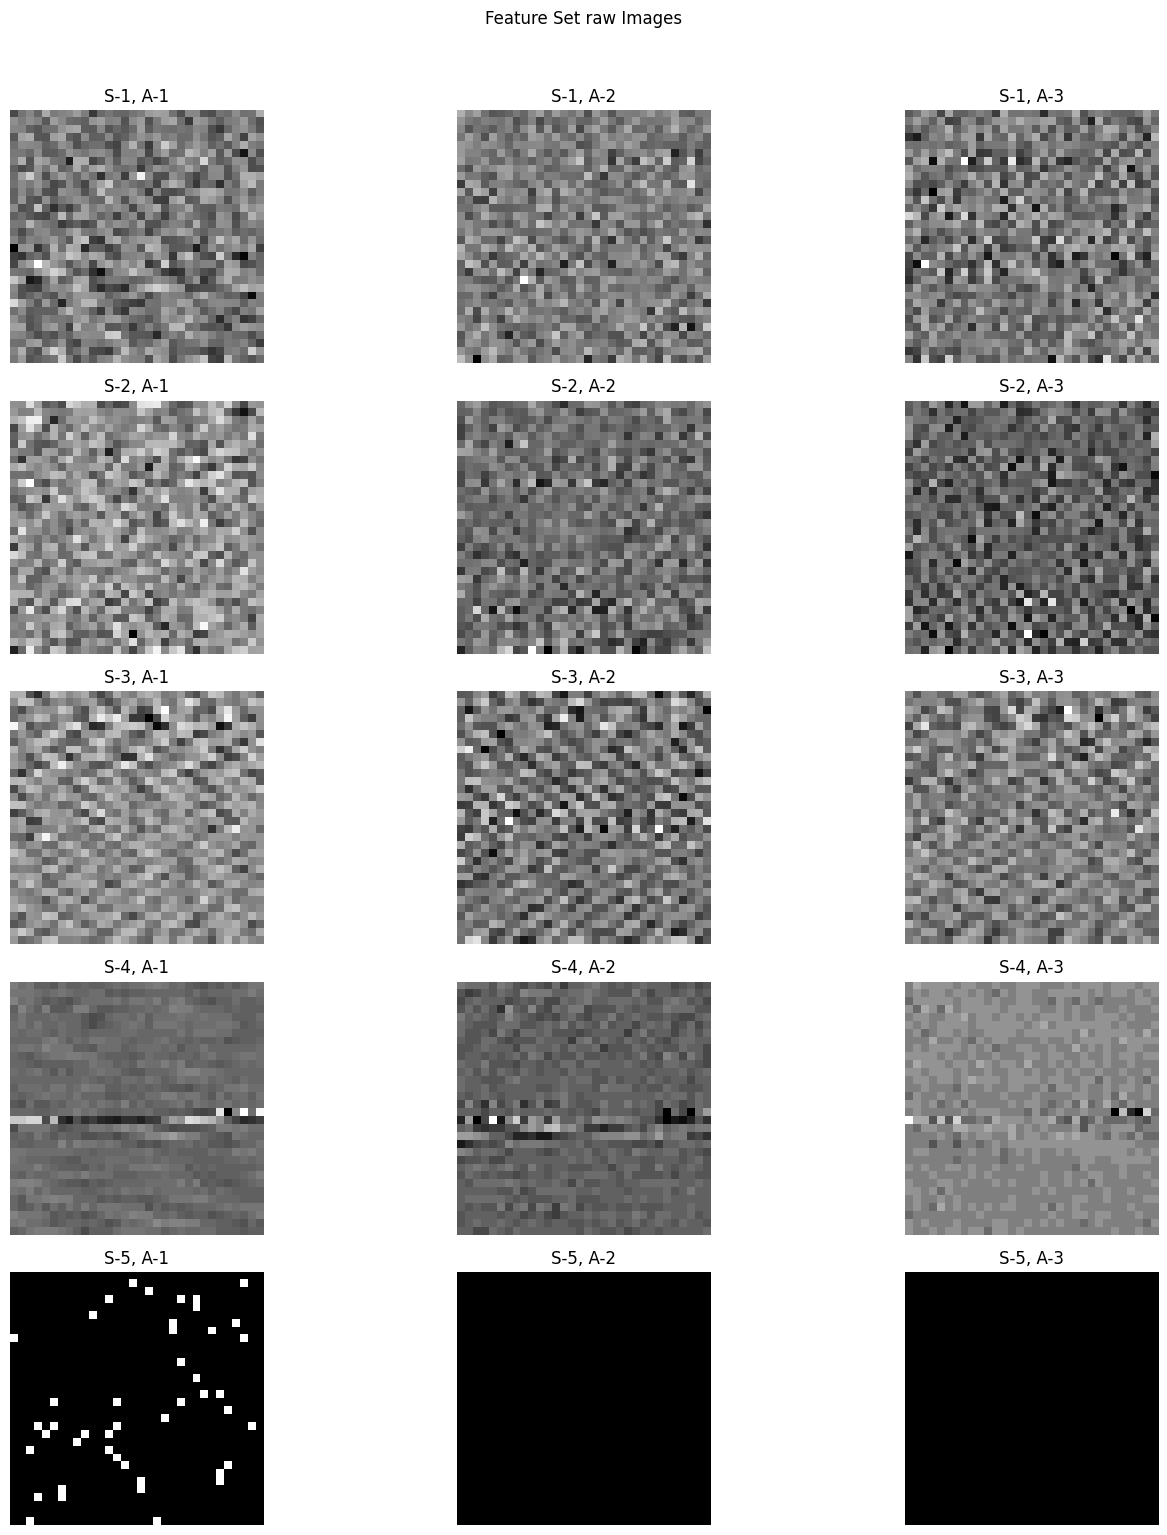

In [ ]:
# Visualize the first few images from Feature Set raw
print("Visualizing Images from Feature Set raw, all axes):")
plot_images(images_raw[:5], title="Feature Set raw Images")

In [ ]:
def plot_keypoints(image, keypoints, title="Image with Keypoints"):
    img_with_kp = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0),
                                    flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_with_kp, cmap='gray')
    plt.title(title)
    plt.axis('off')

def visualize_sample_keypoints(image_samples, num_samples=3):
    for sample_idx in range(min(num_samples, len(image_samples))):
        sample = image_samples[sample_idx]
        num_images = len(sample)

        ncols = 5
        nrows = int(np.ceil(num_images / ncols))

        plt.figure(figsize=(15, 3 * nrows))
        for img_idx, img in enumerate(sample):
            keypoints = get_fast_keypoints(img,n_keypoints=25)
            plt.subplot(nrows, ncols, img_idx + 1)
            plot_keypoints(img, keypoints, title=f"Sample {sample_idx+1} - Img {img_idx+1}")
        plt.tight_layout()
        plt.show()



Visualizing Keypoints on Images from Feature Set raw axes):


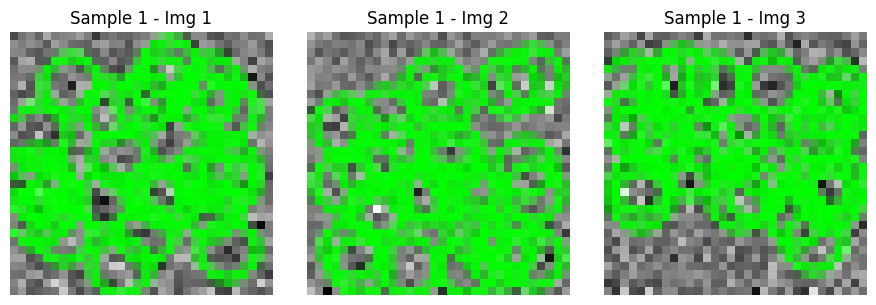

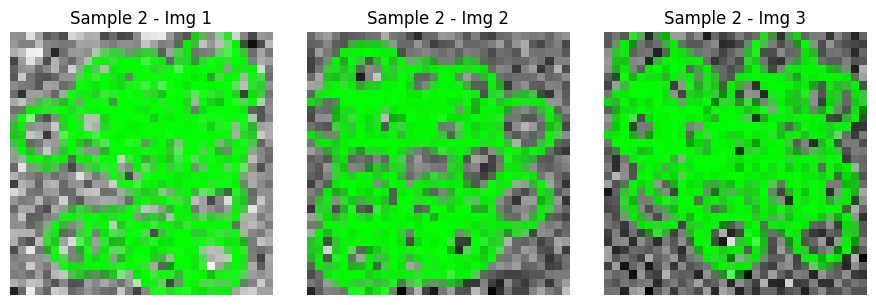

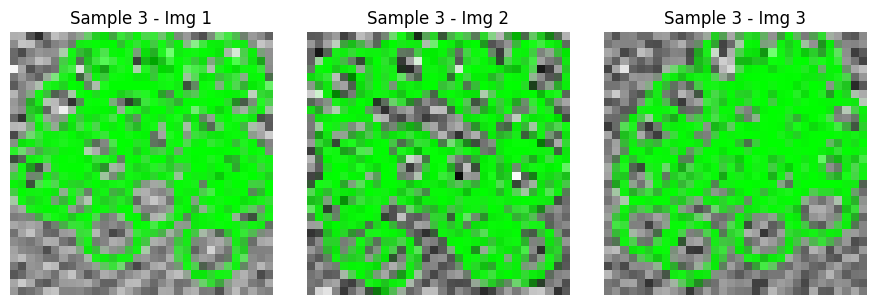

In [ ]:
# Get keypoints for the first few images from Feature Set raw and plot them
print("\nVisualizing Keypoints on Images from Feature Set raw axes):")
visualize_sample_keypoints(image_samples=images_raw, num_samples=3)

In [ ]:
def visualize_descriptor_distribution(descriptors, title="Descriptor Distribution"):

    all_desc_concat = np.vstack(descriptors[:5])

    num_dims_to_plot = 5
    plt.figure(figsize=(12, 2 * num_dims_to_plot))

    for i in range(num_dims_to_plot):
        plt.subplot(num_dims_to_plot, 1, i + 1)
        sns.histplot(all_desc_concat[:, i], kde=True, bins=50)
        plt.title(f'Dimension {i+1} Distribution')
        plt.xlabel('Descriptor Value')
        plt.ylabel('Count')

    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()


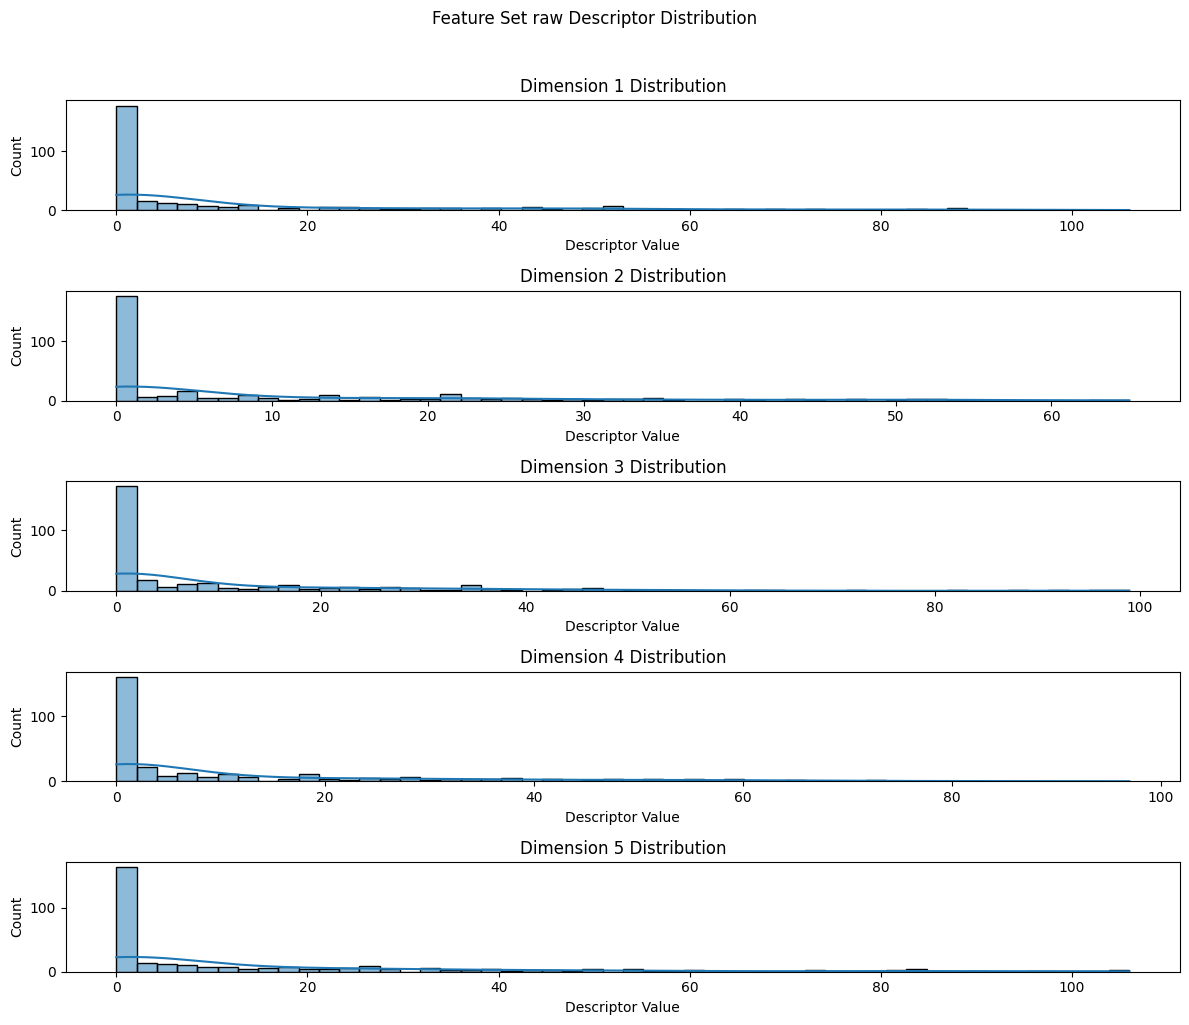

In [ ]:
# Visualize the distribution of descriptors from Feature Set raw
visualize_descriptor_distribution(descriptors_raw_images, title="Feature Set raw Descriptor Distribution")

In [10]:
def imfs_to_images(imfs):
    all_images = []

    for sample in tqdm(imfs, desc="Converting each IMF-Axis to individual images"):
        sample_images = []

        for imf_idx in range(sample.shape[0]):  # iterate over IMFs (e.g., 5)
            for axis in range(3):  # iterate over x, y, z axes
                signal_1d = sample[imf_idx, :, axis]  # shape: (1024,)

                # Normalize to [0,1] and reshape to 32x32 image
                normalized = (signal_1d - np.min(signal_1d)) / (np.ptp(signal_1d) + 1e-8)

                image_normalized = normalized.reshape(32, 32).astype(np.float32)

                image_2d = (image_normalized * 255).astype(np.uint8)

                sample_images.append(image_2d)  # Each shape: (32, 32)

        all_images.append(np.array(sample_images))  # List of 15 images per sample

    return np.array(all_images)  # Final shape: (n_samples, 15, 32, 32)

In [9]:
# Process Feature Set images_1_5 (IMF1-5)
print("\nProcessing Feature Set images_1_5 (IMF1-5):")

images_1_5 = imfs_to_images(imfs)
descriptors_images_1_5 = extract_fast_sift_features(images_1_5)

np.save('images_1_5_train.npy',images_1_5)

with open('descriptors_images_1_5.pkl', 'wb') as f:
    pickle.dump(descriptors_images_1_5, f)


Processing Feature Set images_1_5 (IMF1-5):


Extracting FAST+SIFT Features: 100%|██████████| 24843/24843 [06:47<00:00, 61.01it/s]


In [ ]:
images_1_5.shape

(24843, 15, 32, 32)

Visualizing Images from Feature Set images_1_5):


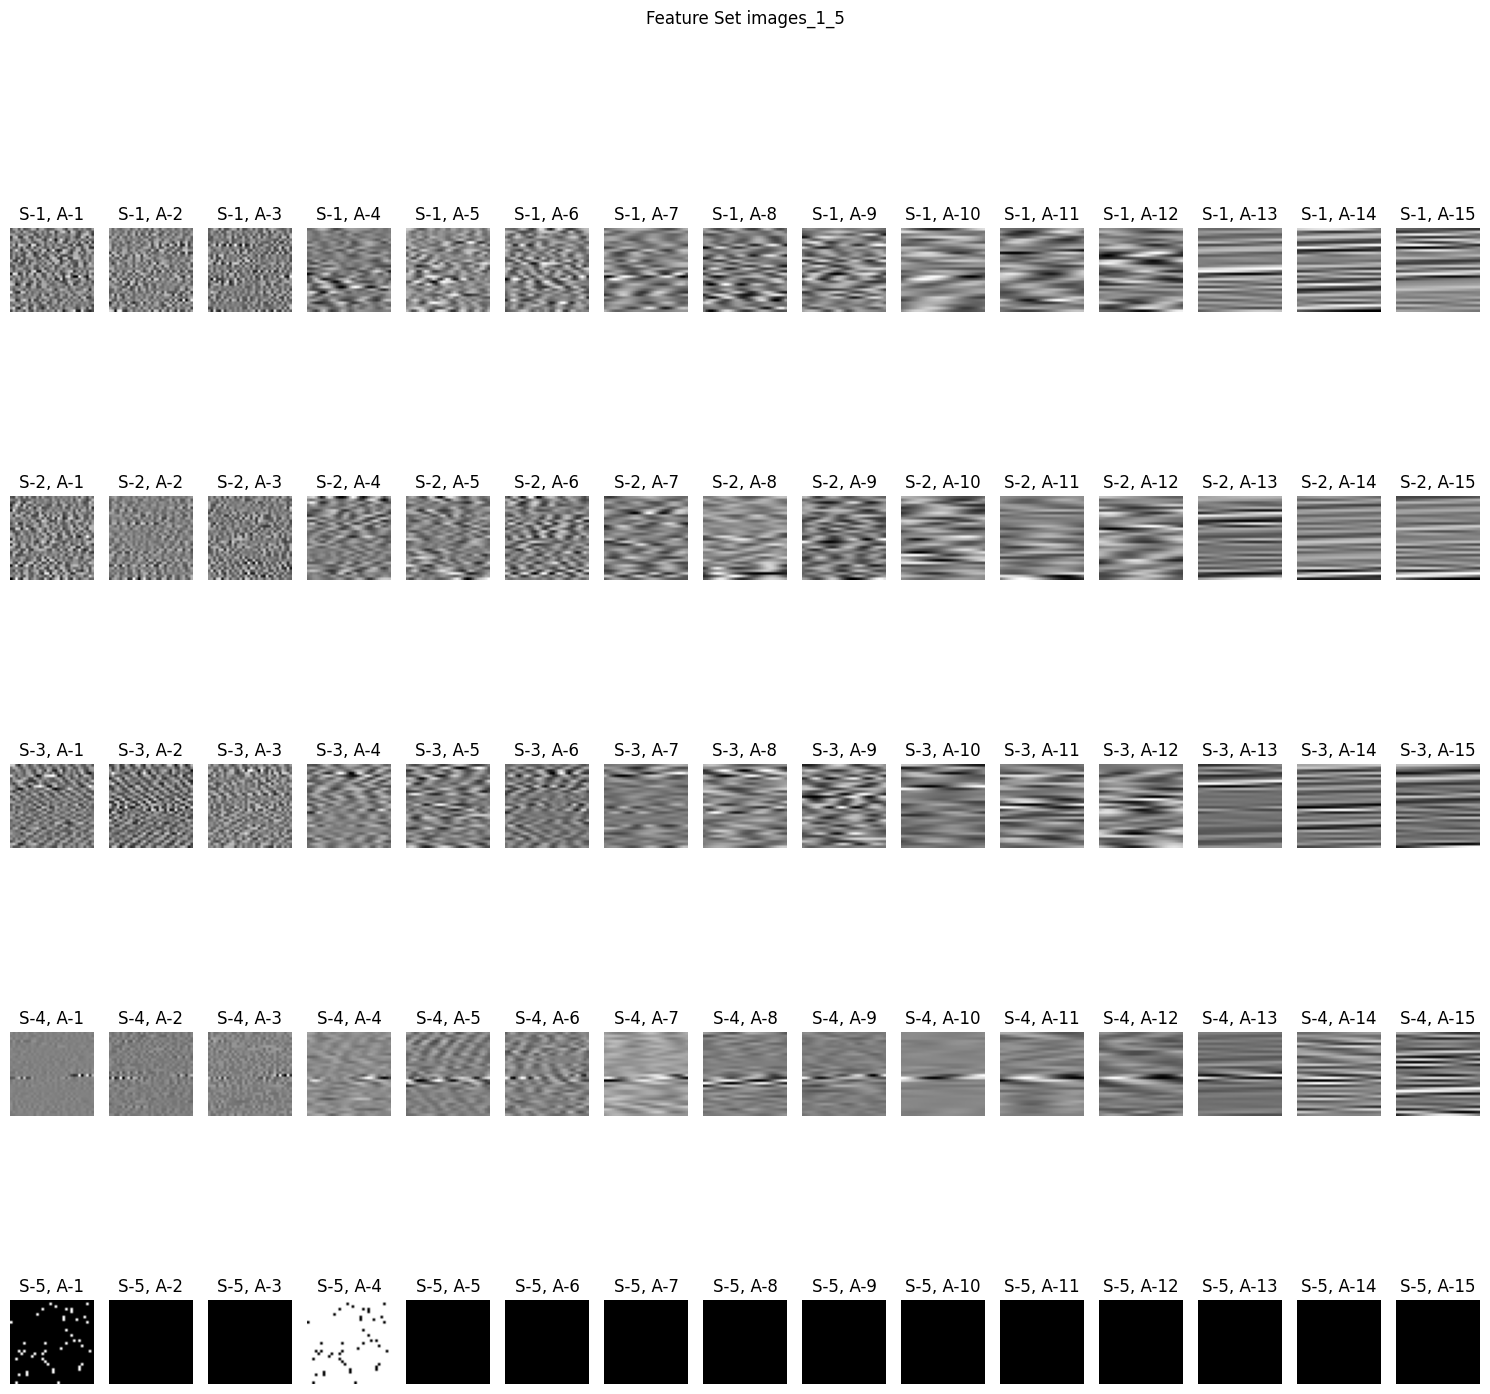

In [ ]:
# Visualize the first few images from Feature Set images_1_5
print("Visualizing Images from Feature Set images_1_5):")
plot_images(images_1_5[:5], title="Feature Set images_1_5")


Visualizing Keypoints on Images from Feature Set images_1_5):


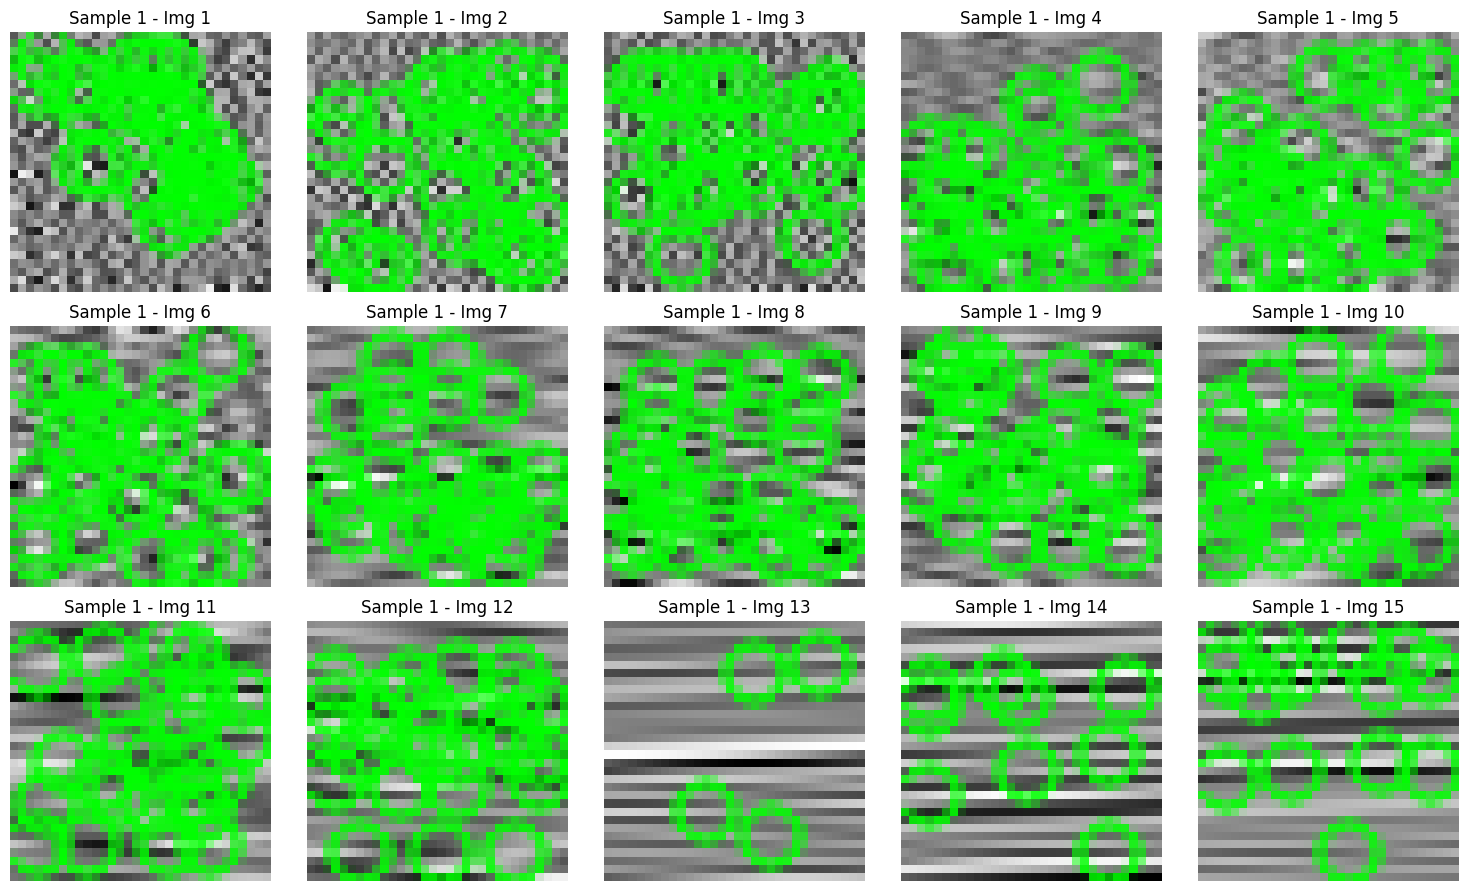

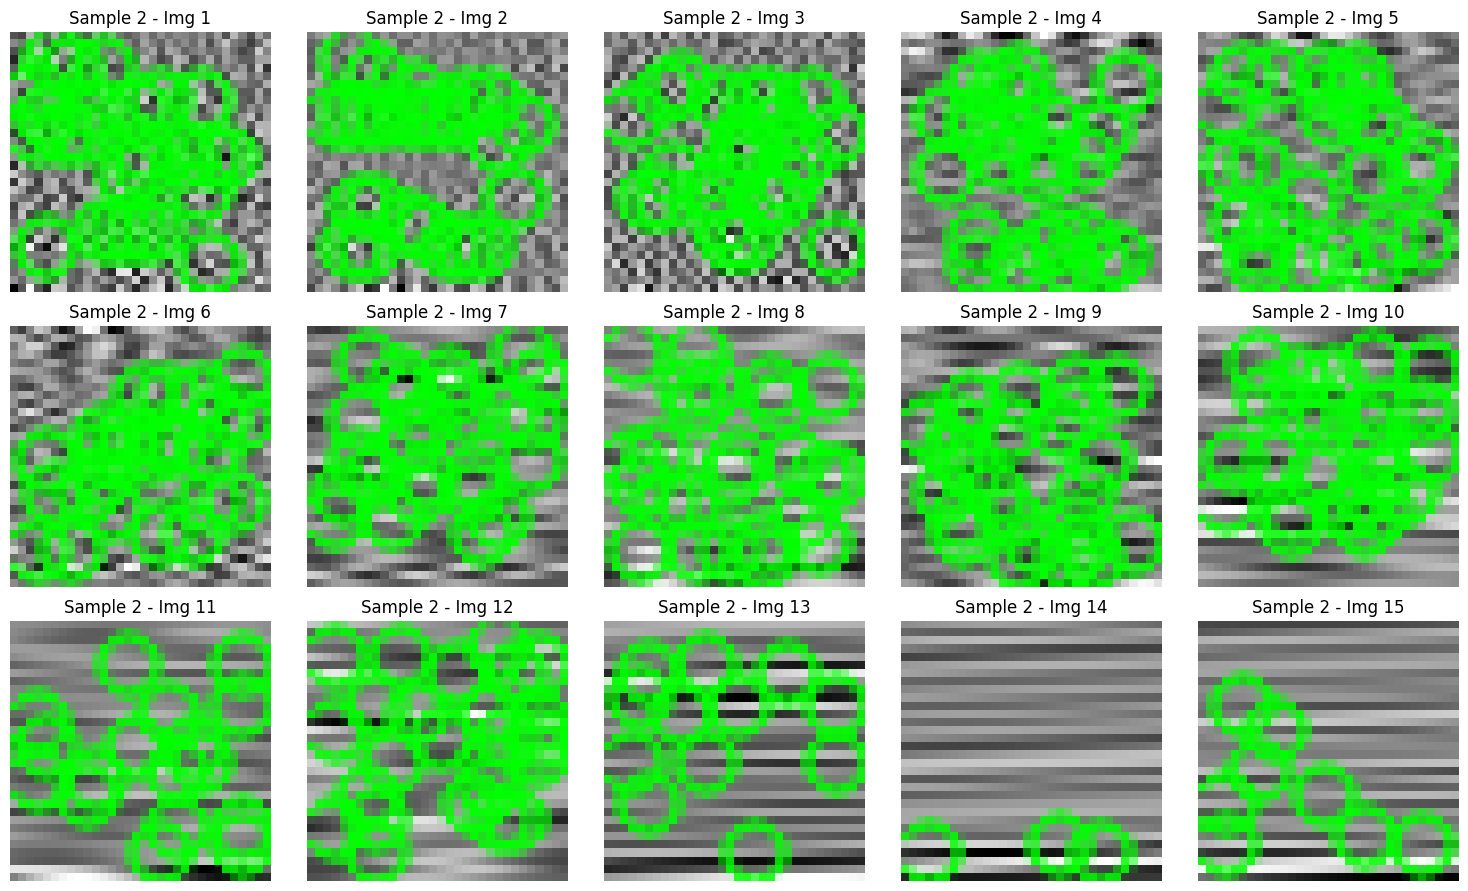

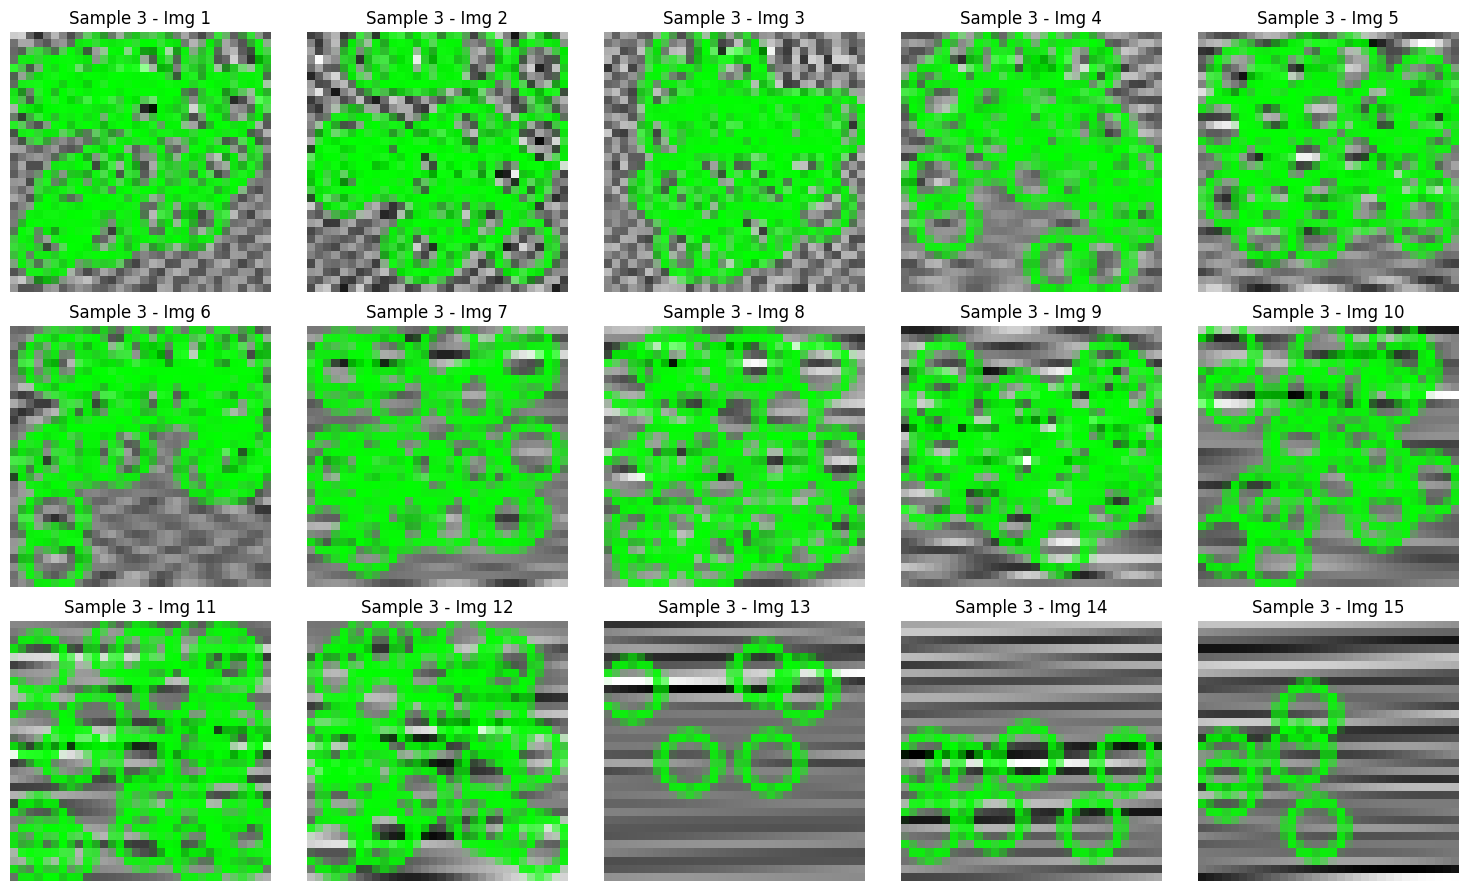

In [ ]:
# Get keypoints for the first few images from Feature Set images_1_5 and plot them
print("\nVisualizing Keypoints on Images from Feature Set images_1_5):")
visualize_sample_keypoints(image_samples=images_1_5, num_samples=3)

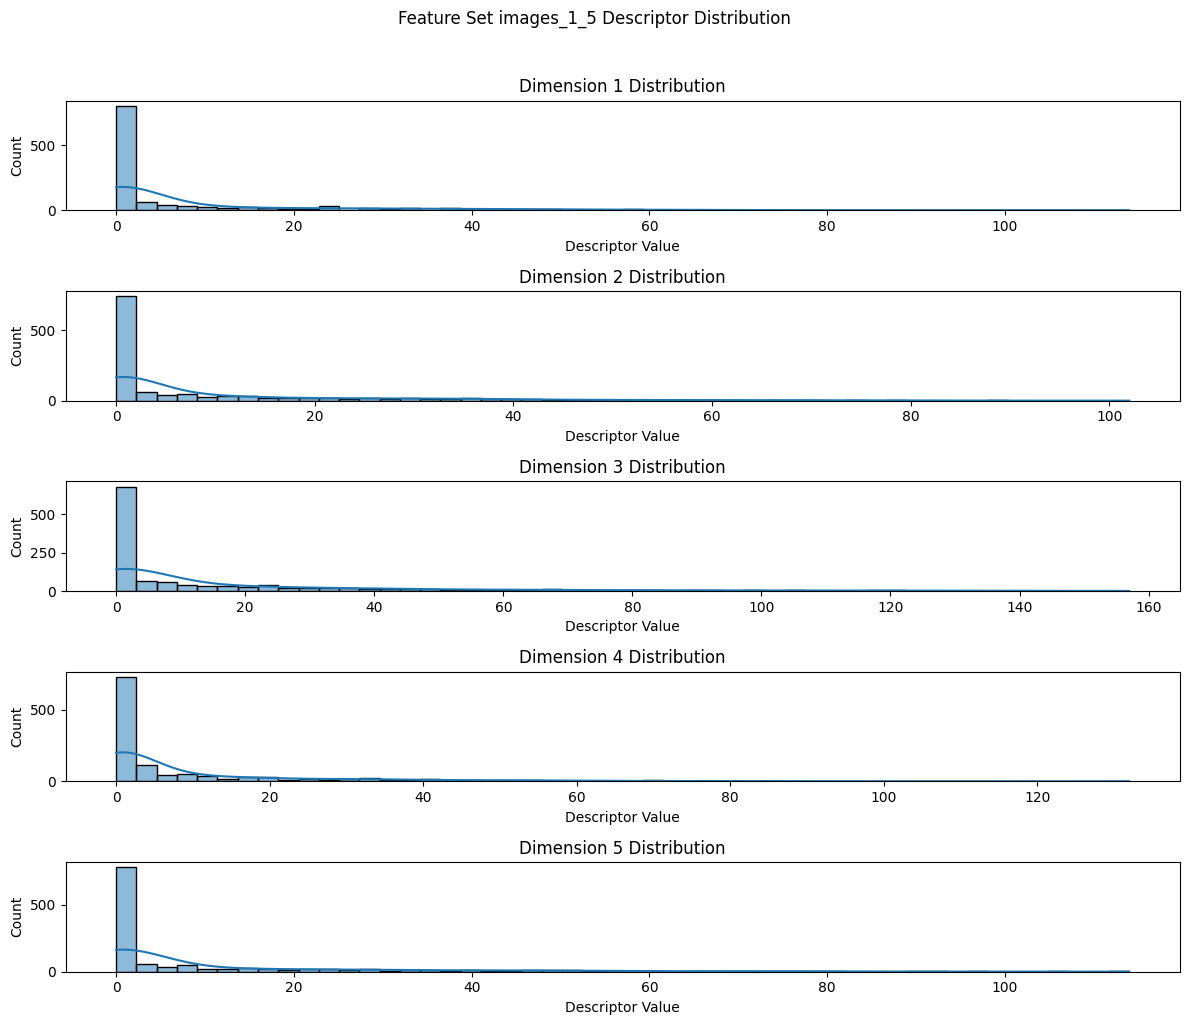

In [ ]:
# Visualize the distribution of descriptors from Feature Set images_1_5
visualize_descriptor_distribution(descriptors_images_1_5, title="Feature Set images_1_5 Descriptor Distribution")

In [56]:
def visual_bow(set_name, signals, n_words=100):
    print(f"\nProcessing {set_name}...")

    descriptors = joblib.load(f"descriptors_{set_name}.pkl")

    all_descriptors = np.concatenate(descriptors, axis=0)
    sample_size = min(500000, len(all_descriptors))
    sample_indices = np.random.choice(len(all_descriptors), sample_size, replace=False)
    sample_descriptors = all_descriptors[sample_indices]

    print(f"Training KMeans with {sample_size} descriptors...")
    kmeans = MiniBatchKMeans(n_clusters=n_words, batch_size=1000, random_state=42)
    kmeans.fit(sample_descriptors)

    print("Creating histograms...")
    histograms = []
    for desc in descriptors:
        labels = kmeans.predict(desc)
        hist = np.bincount(labels, minlength=n_words)
        histograms.append(hist)

    histograms = np.array(histograms)
    normalizer = Normalizer(norm='l2')
    histograms = normalizer.fit_transform(histograms)

    plt.figure(figsize=(12, 6))
    plt.bar(range(histograms.shape[1]), histograms.sum(axis=0))
    plt.title(f'Average BoW Histogram for Feature Set {set_name}')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Average Frequency (Normalized)')
    plt.grid(True)
    plt.show()

    descriptors = []
    all_descriptors = []

    if "raw" in set_name:
      stats = np.array([extract_raw_signal_stats(signal) for signal in signals])
    else:
      stats = np.array([extract_imfs_stats(signal) for signal in signals])

    features = np.hstack([histograms, stats])

    scaler = StandardScaler()
    final_features = scaler.fit_transform(features)

    print(f"\nVisualizing the first few features from features_{set_name}:")

    num_features_to_plot = 5
    plt.figure(figsize=(12, 2 * num_features_to_plot))

    for i in range(min(num_features_to_plot, final_features.shape[1])):
        plt.subplot(num_features_to_plot, 1, i + 1)
        sns.histplot(final_features[:, i], kde=True, bins=50)
        plt.title(f'Distribution of Feature {i+1} (features_{set_name})')
        plt.xlabel('Feature Value')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    np.save(f"bow_features_img_{set_name[7:]}_train.npy",final_features)
    joblib.dump(kmeans,f"bow_model_{set_name}.pkl")
    print(f"Final feature shape: {final_features.shape}")
    return



Processing images_raw...
Training KMeans with 500000 descriptors...
Creating histograms...


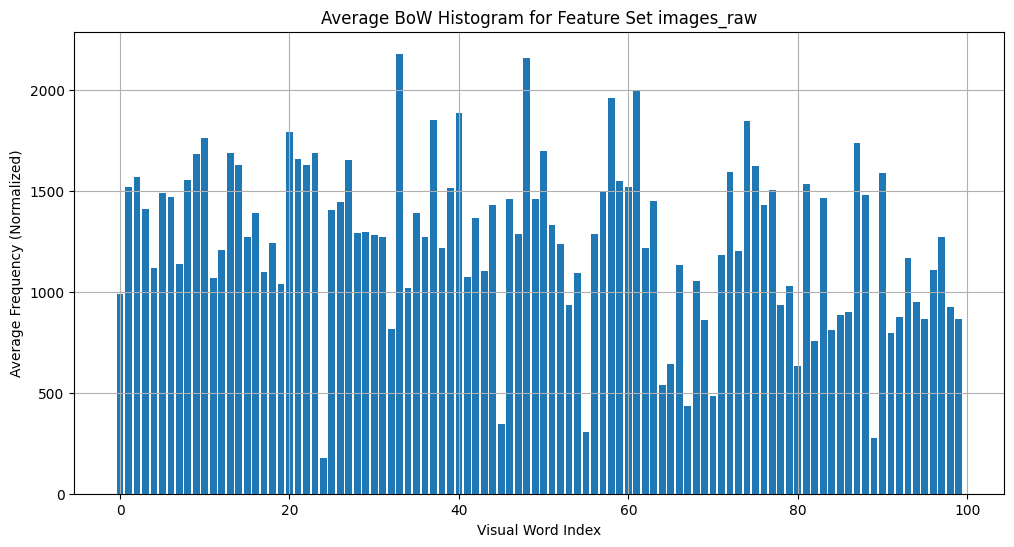


Visualizing the first few features from features_images_raw:


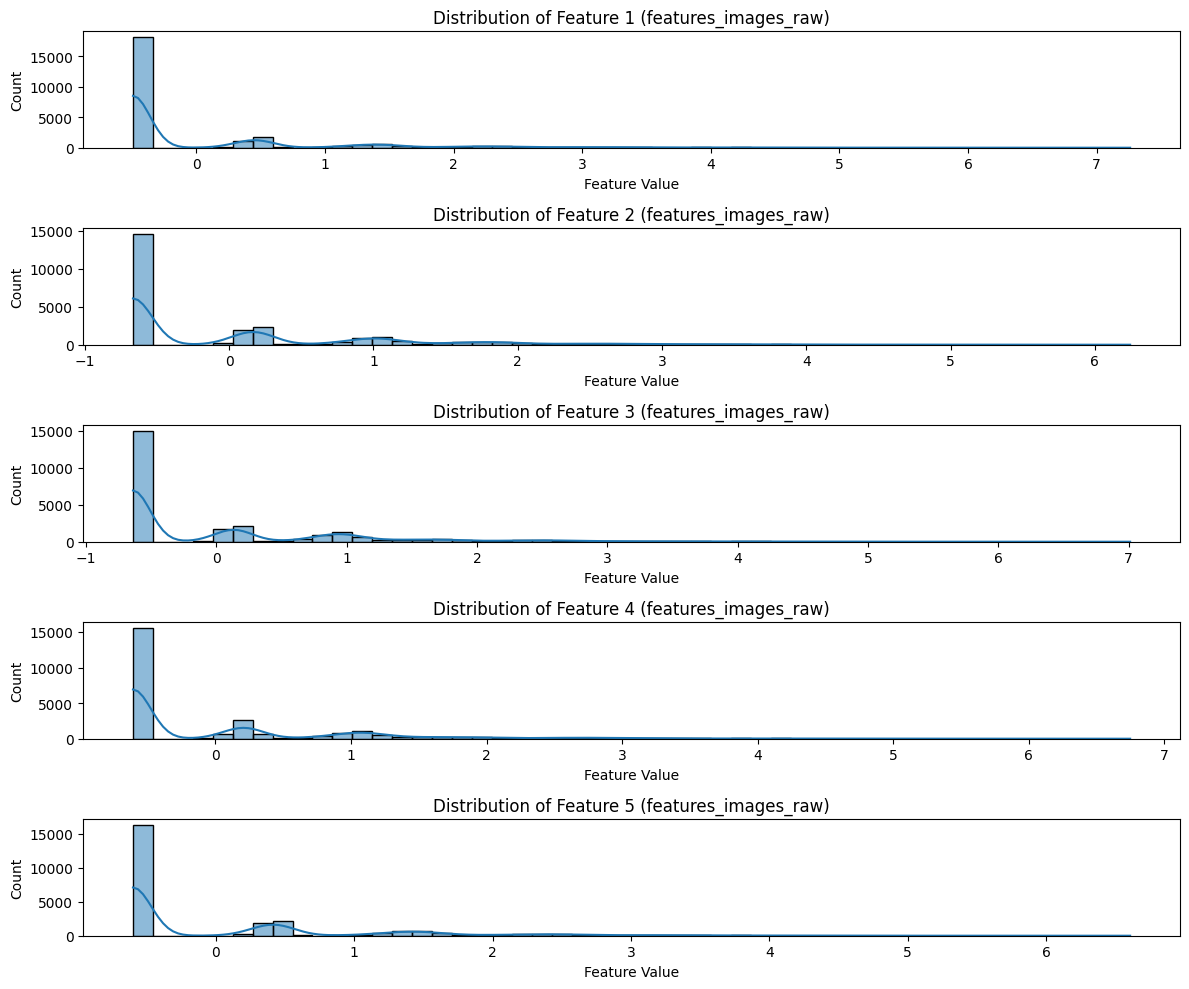

Final feature shape: (24843, 121)


In [57]:
visual_bow("images_raw",X_train_sample)


Processing images_1_5...
Training KMeans with 500000 descriptors...
Creating histograms...


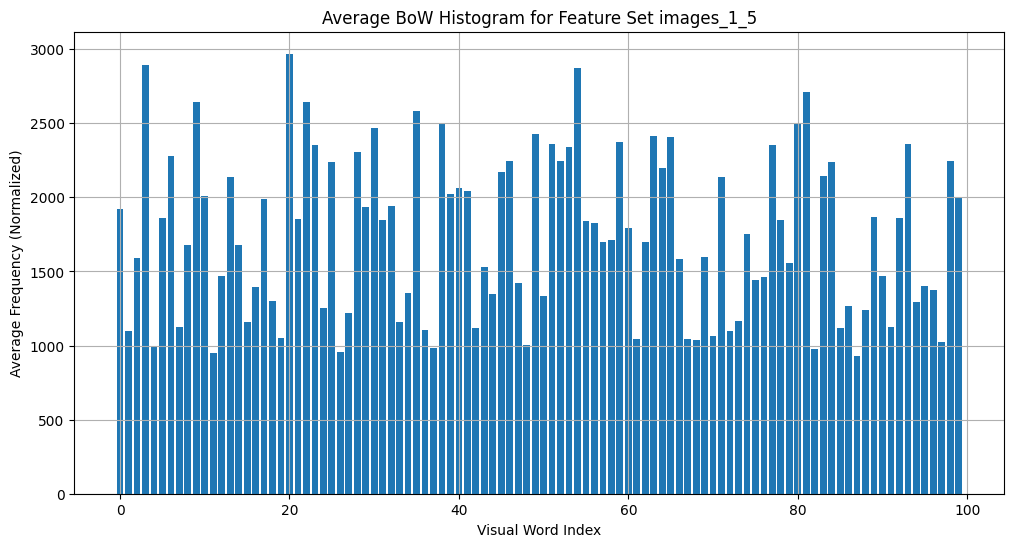


Visualizing the first few features from features_images_1_5:


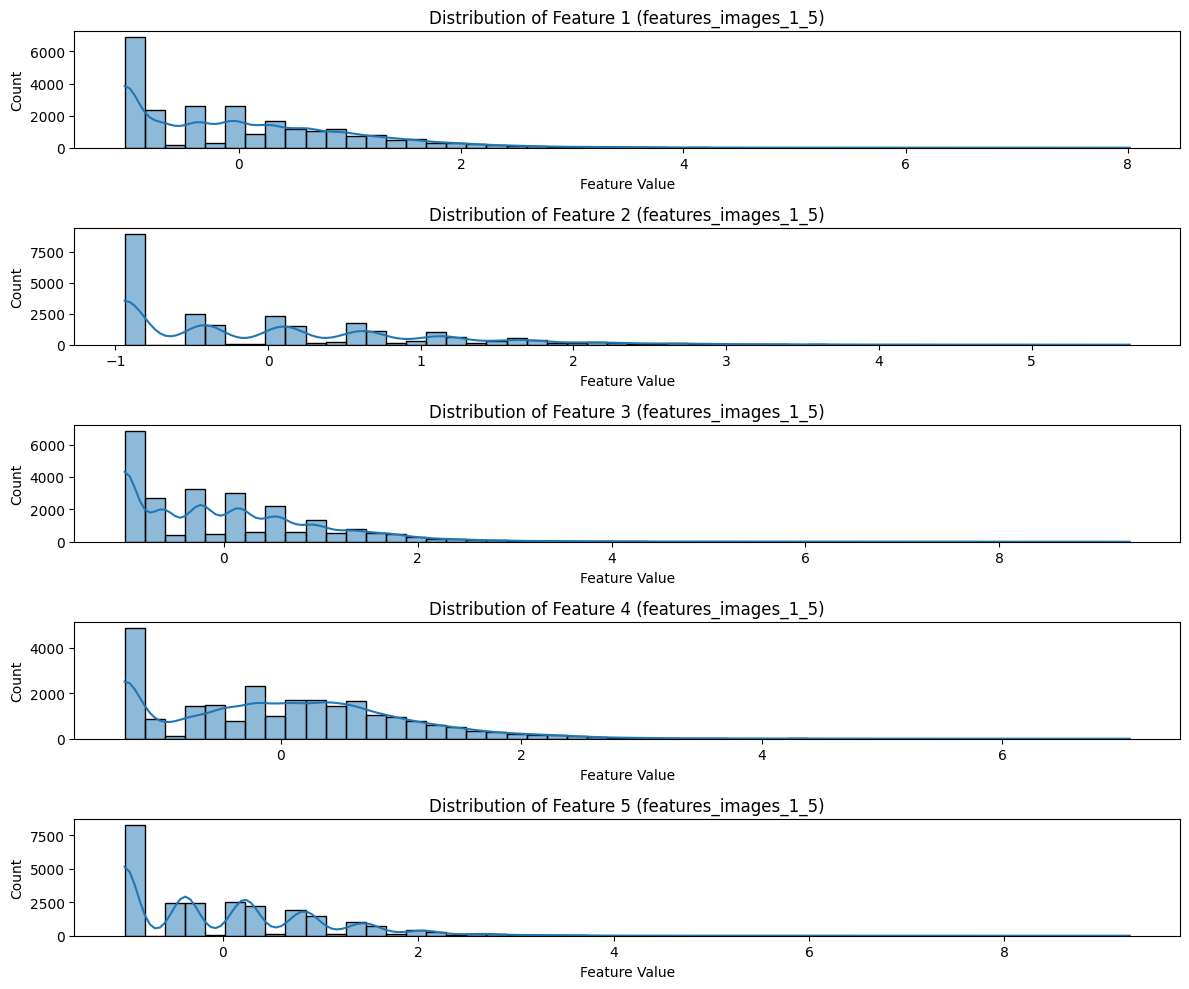

Final feature shape: (24843, 205)


In [6]:
visual_bow("images_1_5",imfs)

In [ ]:
# print("Extracting validation set IMFs")
# val_imfs = emd_all_samples(X_val_sample, max_imfs=5)

# print("Extracting test set IMFs")
# test_imfs = emd_all_samples(X_test_sample, max_imfs=5)

Extracting validation set IMFs
Processing axis 1/3


Samples: 100%|██████████| 5324/5324 [06:03<00:00, 14.65it/s]


Processing axis 2/3


Samples: 100%|██████████| 5324/5324 [02:30<00:00, 35.35it/s]


Processing axis 3/3


Samples: 100%|██████████| 5324/5324 [03:04<00:00, 28.92it/s]


Extracting test set IMFs
Processing axis 1/3


Samples: 100%|██████████| 5325/5325 [05:23<00:00, 16.44it/s]


Processing axis 2/3


Samples: 100%|██████████| 5325/5325 [02:33<00:00, 34.71it/s]


Processing axis 3/3


Samples: 100%|██████████| 5325/5325 [03:48<00:00, 23.28it/s]


In [ ]:
# np.savez_compressed('val_imfs.npz', val_imfs=val_imfs)
# np.savez_compressed('test_imfs.npz', test_imfs=test_imfs)

In [11]:
def process_val_test_sets(samples, signals, kmeans,set_name):
  descriptors = extract_fast_sift_features(samples)

  print("Creating histograms...")
  histograms = []
  for desc in descriptors:
      labels = kmeans.predict(desc)
      hist = np.bincount(labels, minlength=kmeans.n_clusters)
      histograms.append(hist)

  histograms = np.array(histograms)
  normalizer = Normalizer(norm='l2')
  histograms = normalizer.fit_transform(histograms)

  if "raw" in set_name:
    stats = np.array([extract_raw_signal_stats(signal) for signal in signals])
  else:
    stats = np.array([extract_imfs_stats(signal) for signal in signals])

  features = np.hstack([histograms, stats])

  scaler = StandardScaler()
  final_features = scaler.fit_transform(features)
  print(f"Final shape: {final_features.shape}")

  return np.array(final_features)


In [12]:
images_raw_val = raw_signals_to_images(X_val_sample)
images_raw_test = raw_signals_to_images(X_test_sample)
np.save('images_raw_val.npy',images_raw_val)
np.save('images_raw_test.npy',images_raw_test)

Converting each IMF-Axis to individual images: 100%|██████████| 5325/5325 [00:00<00:00, 8535.11it/s]


In [58]:
kmeans_images_raw = joblib.load("bow_model_images_raw.pkl")
feature_images_raw = {
        'val': process_val_test_sets(images_raw_val, X_val_sample, kmeans_images_raw,"images_raw"),
        'test': process_val_test_sets(images_raw_test, X_test_sample, kmeans_images_raw,"images_raw")
}
for split in ['val', 'test']:
        np.save(f'bow_features_img_raw_{split}.npy', feature_images_raw[split])

Extracting FAST+SIFT Features: 100%|██████████| 5324/5324 [00:20<00:00, 263.45it/s]


Creating histograms...
Final shape: (5324, 121)


Extracting FAST+SIFT Features: 100%|██████████| 5325/5325 [00:20<00:00, 253.73it/s]


Creating histograms...
Final shape: (5325, 121)


In [14]:
images_1_5_val = imfs_to_images(val_imfs)
images_1_5_test = imfs_to_images(test_imfs)
np.save('images_1_5_val.npy',images_1_5_val)
np.save('images_1_5_test.npy',images_1_5_test)

Converting each IMF-Axis to individual images: 100%|██████████| 5325/5325 [00:01<00:00, 2806.47it/s]


In [15]:
kmeans_images_1_5 = joblib.load("bow_model_images_1_5.pkl")
feature_images_1_5 = {
        'val': process_val_test_sets(images_1_5_val, val_imfs, kmeans_images_1_5,"images_1_5"),
        'test': process_val_test_sets(images_1_5_test, test_imfs, kmeans_images_1_5,"images_1_5")
}
for split in ['val', 'test']:
        np.save(f'bow_features_img_1_5_{split}.npy', feature_images_1_5[split])

Extracting FAST+SIFT Features: 100%|██████████| 5324/5324 [01:28<00:00, 60.44it/s]


Creating histograms...
Final shape: (5324, 205)


Extracting FAST+SIFT Features: 100%|██████████| 5325/5325 [01:29<00:00, 59.47it/s]


Creating histograms...
Final shape: (5325, 205)


In [59]:
def train_and_evaluate(feature_set_name):
    print(f"\n{'='*40}")
    print(f"Evaluating {feature_set_name} features")
    print(f"{'='*40}")


    X_train = np.load(f'bow_features_{feature_set_name}_train.npy')
    X_val = np.load(f'bow_features_{feature_set_name}_val.npy')

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)

    selector = VarianceThreshold(threshold=1e-5)
    X_train = selector.fit_transform(X_train)
    X_val = selector.transform(X_val)

    joblib.dump(scaler, "scaler.pkl")
    joblib.dump(imputer, "imputer.pkl")
    joblib.dump(selector, "selector.pkl")

    classes = np.unique(y_train)
    sgd_class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    sgd_class_weight_dict = dict(zip(classes, sgd_class_weights))
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

    svm = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    alpha=0.001,
    l1_ratio=0.3,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    max_iter=1000,
    random_state=42,
    class_weight=sgd_class_weight_dict
    )

    xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0,
    scale_pos_weight=scale_pos_weight,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42
    )

    lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    class_weight='balanced',
    objective='binary',
    min_gain_to_split=1e-3,
    random_state=42,
    verbosity=-1
    )

    print("Training XGBoost...")
    xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)


    print("Training LightGBM...")
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],callbacks=[early_stopping(stopping_rounds=50)]) # Removed verbosity from fit

    print("Training SVM (fit)...")
    svm.fit(X_train, y_train)

    def evaluate(model, X, y):
        pred = model.predict(X)
        try:
            proba = model.predict_proba(X)[:,1] if hasattr(model, 'predict_proba') else None
            roc_auc = roc_auc_score(y, proba) if proba is not None else 0.5
        except ValueError:
            roc_auc = 0.5

        return {
            'accuracy': accuracy_score(y, pred),
            'precision': precision_score(y, pred, zero_division=0),
            'recall': recall_score(y, pred, zero_division=0),
            'f1': f1_score(y, pred, zero_division=0),
            'roc_auc': roc_auc
            }
    X_test = np.load(f'bow_features_{feature_set_name}_test.npy')

    X_test = scaler.transform(X_test)
    X_test = imputer.transform(X_test)
    X_test = selector.transform(X_test)
    return {
            'svm': evaluate(svm, X_test, y_test),
            'xgb': evaluate(xgb, X_test, y_test),
            'lgbm': evaluate(lgbm, X_test, y_test),
        }


In [60]:
results = {}
for set_name in ['img_raw','img_1_5']:
    results[set_name] = train_and_evaluate(set_name)
print("\nFinal Test Performance:")
print("{:<10} | {:<8} | {:<6} | {:<6} | {:<6} | {:<6} | {:<6}".format(
    "Feature Set", "Model", "Acc", "Prec", "Rec", "F1", "AUC"))
print("-"*65)

for set_name, metrics in results.items():
    for model_name in ['xgb','lgbm','svm']:
        scores = metrics[model_name]
        print("{:<10} | {:<8} | {:.4f} | {:.4f} | {:.4f} | {:.4f} | {:.4f}".format(
            set_name if model_name == 'svm' else '',
            model_name.upper(),
            scores['accuracy'],
            scores['precision'],
            scores['recall'],
            scores['f1'],
            scores['roc_auc']
        ))


Evaluating img_raw features
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:55:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training LightGBM...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's binary_logloss: 0.248836
Training SVM (fit)...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [17:55:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Evaluating img_1_5 features
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:55:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training LightGBM...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's binary_logloss: 0.264299
Training SVM (fit)...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [17:55:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Final Test Performance:
Feature Set | Model    | Acc    | Prec   | Rec    | F1     | AUC   
-----------------------------------------------------------------
           | XGB      | 0.9099 | 0.9358 | 0.9124 | 0.9239 | 0.9705
           | LGBM     | 0.9082 | 0.9387 | 0.9061 | 0.9221 | 0.9677
img_raw    | SVM      | 0.8220 | 0.8977 | 0.7937 | 0.8425 | 0.8889
           | XGB      | 0.9005 | 0.9805 | 0.8510 | 0.9112 | 0.9794
           | LGBM     | 0.9159 | 0.9738 | 0.8836 | 0.9265 | 0.9629
img_1_5    | SVM      | 0.8511 | 0.9247 | 0.8185 | 0.8683 | 0.9328


In [61]:
converted_results = {}

for metric in ["accuracy","precision","recall","f1","roc_auc"]:
    converted_results[metric] = {}
    for model_name in ["xgb","lgbm","svm"]:
        converted_results[metric][model_name] = {}
        for fs, models in results.items():
            converted_results[metric][model_name][fs] = models[model_name][metric]

with open('images_results_new.json', 'w') as f:
    json.dump(converted_results, f, indent=2)

print("Converted results saved to images_results_new.json")

Converted results saved to images_results_new.json


In [20]:
class IMGDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.from_numpy(images).float()  # (N, C, H, W)
        self.labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [21]:
# CNN Model
class IMG_CNN(nn.Module):
    def __init__(self, input_channels):
        super(IMG_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.classifier(self.features(x)).squeeze()

In [22]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none', pos_weight=self.pos_weight
        )
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * ((1 - pt) ** self.gamma) * BCE_loss
        return loss.mean()

In [27]:
# Training Function
def train_cnn_images(feature_set_name, y_train, y_val, y_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load preprocessed IMF images (shape: N, C, H, W)
    X_train = np.load(f"{feature_set_name}_train.npy")
    X_val = np.load(f"{feature_set_name}_val.npy")
    X_test = np.load(f"{feature_set_name}_test.npy")

    # Ensure dtype and shape
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Preprocessing (flatten → scale → reshape)
    def preprocess(X, fit=False, scaler=None, imputer=None):
        N, C, H, W = X.shape
        X_flat = X.reshape(N, -1)

        if fit:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_flat)
            imputer = SimpleImputer(strategy="mean")
            X_imputed = imputer.fit_transform(X_scaled)
            return X_imputed.reshape(N, C, H, W), scaler, imputer
        else:
            X_scaled = scaler.transform(X_flat)
            X_imputed = imputer.transform(X_scaled)
            return X_imputed.reshape(N, C, H, W)


    X_train, scaler, imputer = preprocess(X_train, fit=True)
    X_val = preprocess(X_val, scaler=scaler, imputer=imputer)
    X_test = preprocess(X_test, scaler=scaler, imputer=imputer)

    # Datasets and Loaders
    train_dataset = IMGDataset(X_train, y_train)
    val_dataset = IMGDataset(X_val, y_val)
    test_dataset = IMGDataset(X_test, y_test)

    # Weighted Sampler
    class_weights = 1.0 / np.bincount(y_train.astype(int))
    sample_weights = class_weights[y_train.astype(int)]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = IMG_CNN(input_channels=X_train.shape[1]).to(device)

    pos_weight = torch.tensor([np.sum(y_train == 0) / np.sum(y_train == 1)], dtype=torch.float).to(device)
    criterion = FocalLoss(alpha=1.0, gamma=2.0, pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

    best_val_auc, best_thresh = 0, 0.5
    patience, max_patience = 0, 5

    train_auc_history, val_auc_history = [], []
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    # Training Loop
    for epoch in range(40):
        model.train()
        all_preds, all_labels, total_loss = [], [], 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            all_preds += torch.sigmoid(out).detach().cpu().tolist()
            all_labels += y.cpu().tolist()

        train_loss = total_loss / len(train_loader.dataset)
        train_auc = roc_auc_score(all_labels, all_preds)
        train_acc = accuracy_score(all_labels, np.round(all_preds))

        model.eval()
        val_preds, val_labels, val_loss = [], [], 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)
                val_preds += torch.sigmoid(out).cpu().tolist()
                val_labels += y.cpu().tolist()

        val_loss /= len(val_loader.dataset)
        val_auc = roc_auc_score(val_labels, val_preds)
        val_acc = accuracy_score(val_labels, np.round(val_preds))
        scheduler.step(val_auc)

        train_auc_history.append(train_auc)
        val_auc_history.append(val_auc)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1:02d} — Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} — "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} — "
              f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), f"best_model_{feature_set_name}.pth")
            patience = 0
        else:
            patience += 1
            if patience >= max_patience:
                print("Early stopping.")
                break

        for t in np.linspace(0.3, 0.7, 21):
            f1 = f1_score(val_labels, (np.array(val_preds) > t).astype(int))
            if f1 > best_val_auc:
                best_thresh = t

    # Test
    model.load_state_dict(torch.load(f"best_model_{feature_set_name}.pth"))
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            test_preds += torch.sigmoid(model(x)).cpu().tolist()
            test_labels += y.cpu().tolist()

    test_preds_bin = (np.array(test_preds) > best_thresh).astype(int)
    test_metrics = {
        "accuracy": accuracy_score(test_labels, test_preds_bin),
        "precision": precision_score(test_labels, test_preds_bin, zero_division=0),
        "recall": recall_score(test_labels, test_preds_bin, zero_division=0),
        "f1": f1_score(test_labels, test_preds_bin, zero_division=0),
        "roc_auc": roc_auc_score(test_labels, test_preds),
        "confusion_matrix": confusion_matrix(test_labels, test_preds_bin)
    }

    # Plot training curves
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_auc_history, label="Train AUC")
    plt.plot(val_auc_history, label="Val AUC")
    plt.title(f"AUC - {feature_set_name}")
    plt.legend(); plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.title(f"Loss - {feature_set_name}")
    plt.legend(); plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.title(f"Accuracy - {feature_set_name}")
    plt.legend(); plt.grid()

    plt.tight_layout()
    plt.show()

    return test_metrics


In [62]:
with open("images_results_new.json",'r') as f:
  results = json.load(f)

In [25]:
cnn_results = {}
for i in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  cnn_results[i] = {}
  cnn_results[i]['cnn'] = {}


Training CNN on feature set raw  
Epoch 01 — Train Loss: 0.0496 | Val Loss: 0.0314 — Train Acc: 0.8608 | Val Acc: 0.8958 — Train AUC: 0.9394 | Val AUC: 0.9756
Epoch 02 — Train Loss: 0.0366 | Val Loss: 0.0422 — Train Acc: 0.9020 | Val Acc: 0.9083 — Train AUC: 0.9658 | Val AUC: 0.9708
Epoch 03 — Train Loss: 0.0329 | Val Loss: 0.1204 — Train Acc: 0.9120 | Val Acc: 0.6670 — Train AUC: 0.9717 | Val AUC: 0.9390
Epoch 04 — Train Loss: 0.0296 | Val Loss: 0.0444 — Train Acc: 0.9219 | Val Acc: 0.9098 — Train AUC: 0.9762 | Val AUC: 0.9710
Epoch 05 — Train Loss: 0.0266 | Val Loss: 0.0290 — Train Acc: 0.9306 | Val Acc: 0.9410 — Train AUC: 0.9808 | Val AUC: 0.9817
Epoch 06 — Train Loss: 0.0236 | Val Loss: 0.0267 — Train Acc: 0.9401 | Val Acc: 0.9470 — Train AUC: 0.9840 | Val AUC: 0.9857
Epoch 07 — Train Loss: 0.0230 | Val Loss: 0.0328 — Train Acc: 0.9413 | Val Acc: 0.8922 — Train AUC: 0.9848 | Val AUC: 0.9817
Epoch 08 — Train Loss: 0.0230 | Val Loss: 0.0260 — Train Acc: 0.9422 | Val Acc: 0.9078 — T

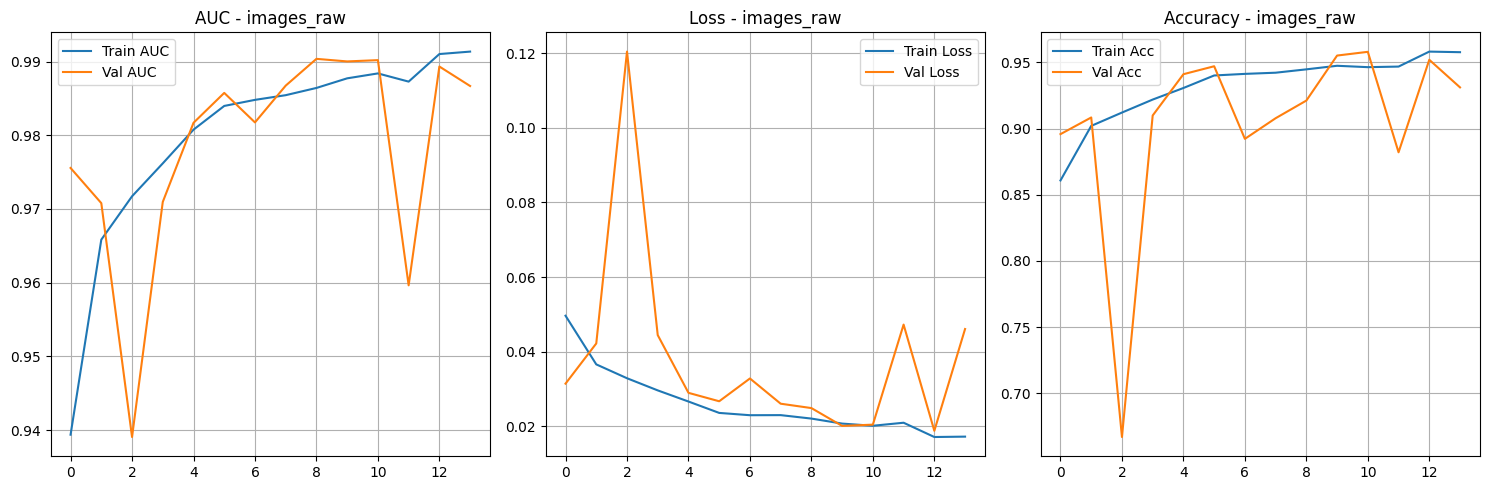


Test Metrics for feature set raw:
Accuracy: 0.9140
Precision: 0.9957
Recall: 0.8604
F1: 0.9231
Roc_auc: 0.9893
Confusion_matrix:
[[2118   12]
 [ 446 2749]]


In [31]:
print(f"\nTraining CNN on feature set raw  ")
metrics = train_cnn_images('images_raw',y_train, y_val, y_test)

print(f"\nTest Metrics for feature set raw:")
for key, value in metrics.items():
    if key == 'confusion_matrix':
        print(f"{key.capitalize()}:\n{value}")
    else:
      cnn_results[key]['cnn']['img_raw'] = value
      print(f"{key.capitalize()}: {value:.4f}")


Training CNN on feature set images_1_5
Epoch 01 — Train Loss: 0.0518 | Val Loss: 0.0459 — Train Acc: 0.8464 | Val Acc: 0.8238 — Train AUC: 0.9333 | Val AUC: 0.9723
Epoch 02 — Train Loss: 0.0373 | Val Loss: 0.0399 — Train Acc: 0.9025 | Val Acc: 0.8516 — Train AUC: 0.9641 | Val AUC: 0.9716
Epoch 03 — Train Loss: 0.0328 | Val Loss: 0.2025 — Train Acc: 0.9120 | Val Acc: 0.4683 — Train AUC: 0.9711 | Val AUC: 0.8457
Epoch 04 — Train Loss: 0.0319 | Val Loss: 0.3530 — Train Acc: 0.9157 | Val Acc: 0.7750 — Train AUC: 0.9737 | Val AUC: 0.9454
Epoch 05 — Train Loss: 0.0268 | Val Loss: 0.0225 — Train Acc: 0.9292 | Val Acc: 0.9292 — Train AUC: 0.9808 | Val AUC: 0.9877
Epoch 06 — Train Loss: 0.0246 | Val Loss: 0.0283 — Train Acc: 0.9366 | Val Acc: 0.9485 — Train AUC: 0.9831 | Val AUC: 0.9838
Epoch 07 — Train Loss: 0.0231 | Val Loss: 0.0243 — Train Acc: 0.9415 | Val Acc: 0.9311 — Train AUC: 0.9849 | Val AUC: 0.9875
Epoch 08 — Train Loss: 0.0227 | Val Loss: 0.0213 — Train Acc: 0.9434 | Val Acc: 0.937

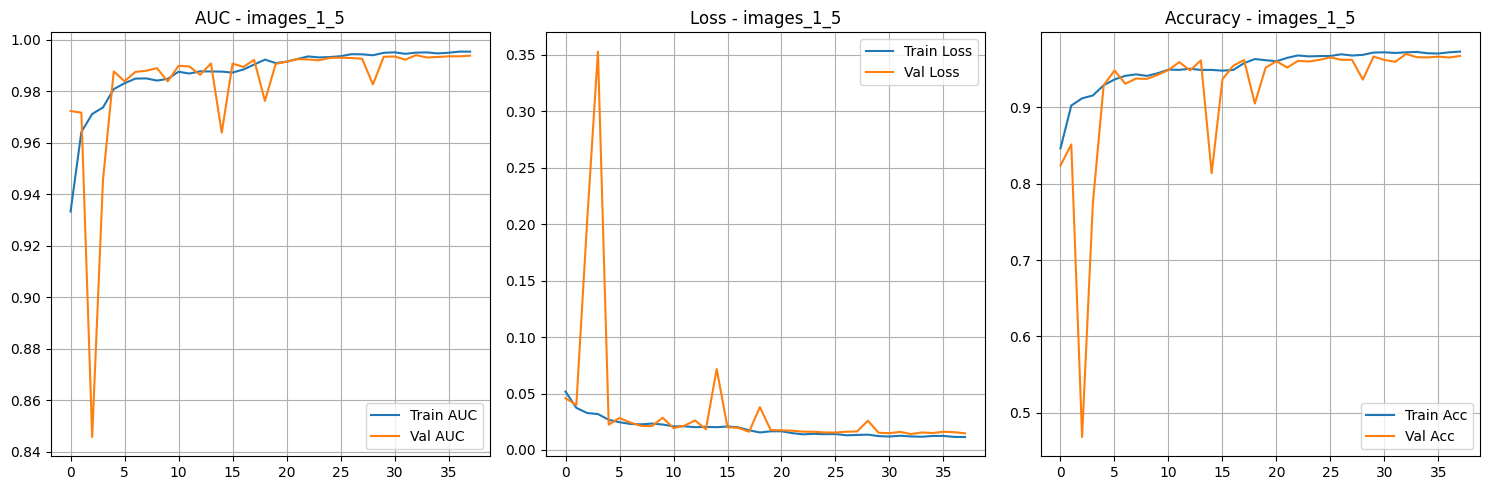


Test Metrics for feature set images_1_5:
Accuracy: 0.9638
Precision: 0.9873
Recall: 0.9518
F1: 0.9692
Roc_auc: 0.9938
Confusion_matrix:
[[2091   39]
 [ 154 3041]]


In [29]:
print(f"\nTraining CNN on feature set images_1_5")
metrics = train_cnn_images('images_1_5',y_train, y_val, y_test)

print(f"\nTest Metrics for feature set images_1_5:")
for key, value in metrics.items():
    if key == 'confusion_matrix':
        print(f"{key.capitalize()}:\n{value}")
    else:
      cnn_results[key]['cnn']['img_1_5'] = value
      print(f"{key.capitalize()}: {value:.4f}")

In [32]:
with open('cnn_images_results.json', 'w') as f:
    json.dump(cnn_results, f, indent=2)

In [33]:
with open('cnn_images_results.json', 'r') as f:
    cnn_results = json.load(f)

In [46]:
def plot_average_results(results,feature,models):
  for metric,samples in results.items():
    data = samples
    sorted_data = sorted([[data[key],key] for key in data.keys()],reverse = True)
    labels = [i[1] for i in sorted_data]
    values = [i[0] for i in sorted_data]

    colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    plt.figure(figsize=(4, 6))
    bars = plt.bar(labels, values, color=colors)

    plt.ylabel('Value')
    plt.title(f'average of {models} {metric} of each {feature} sample')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom') # Convert to string

    plt.tight_layout()
    plt.show()

In [43]:
def plot_cnn_results(results,feature):
  for metric,samples in results.items():
    data = samples
    sorted_data = sorted([[data[key],key] for key in data.keys()],reverse = True)
    labels = [i[1] for i in sorted_data]
    values = [i[0] for i in sorted_data]

    colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    plt.figure(figsize=(4, 6))
    bars = plt.bar(labels, values, color=colors)

    plt.ylabel('Value')
    plt.title(f'cnn {metric} of each {feature} sample')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom') # Convert to string

    plt.tight_layout()
    plt.show()

In [37]:
with open("cnn_images_results.json","r") as f:
  cnn_results = json.load(f)

In [63]:
for metric in results.keys():
  results[metric]['cnn'] = {}
  for i in cnn_results[metric]['cnn'].keys():
    results[metric]['cnn'][i] = cnn_results[metric]['cnn'][i]

In [39]:
cnn_results['accuracy'].keys()

dict_keys(['cnn'])

In [64]:
with open("images_results_new.json","w") as f:
  json.dump(results,f,indent=2)

In [41]:
cnn_img_results = {}
for metric,models in cnn_results.items():
  cnn_img_results[metric]={}
  for i in ['img_raw','img_1_5']:
    cnn_img_results[metric][i] = models["cnn"][i]

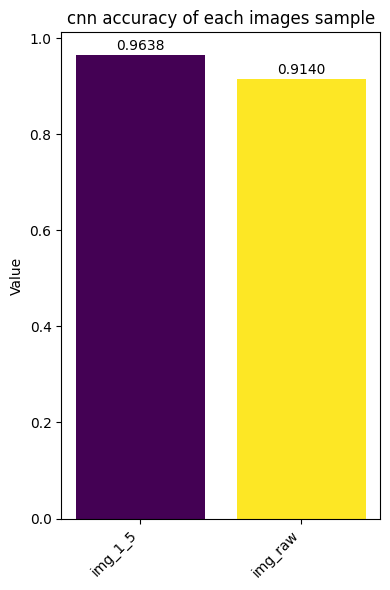

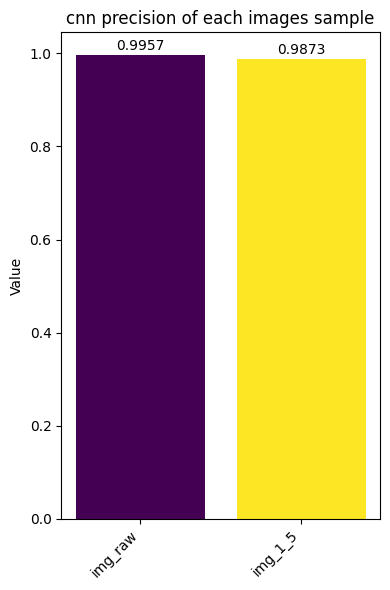

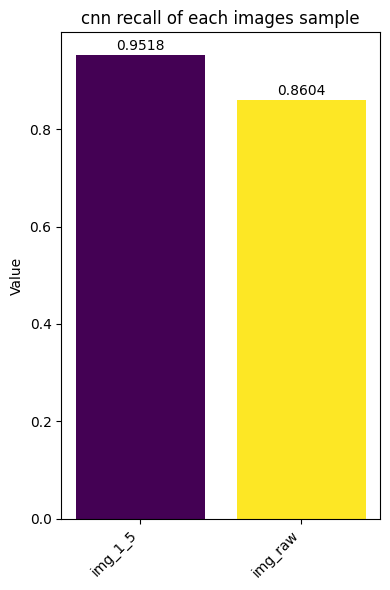

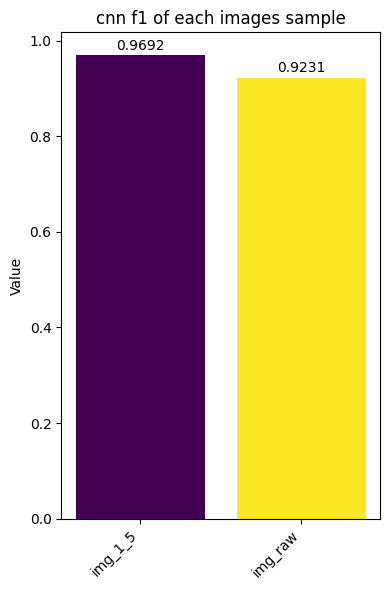

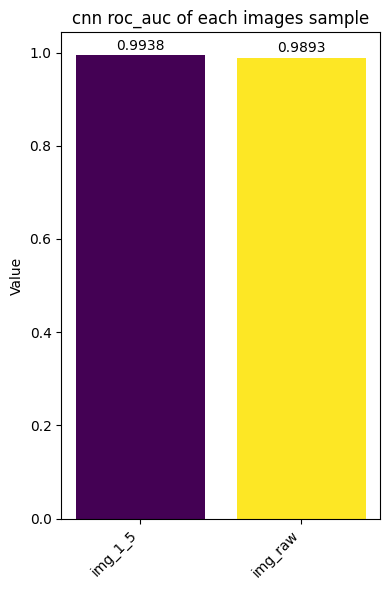

In [44]:
plot_cnn_results(cnn_img_results,"images")

In [65]:
with open("images_results_new.json",'r') as f:
  results = json.load(f)

In [66]:
average_images_results = {}
for metric,models in results.items():
  average_images_results[metric]={}
  for i in ['img_raw','img_1_5']:
    average_images_results[metric][i] = (models["xgb"][i]+models["lgbm"][i])/2

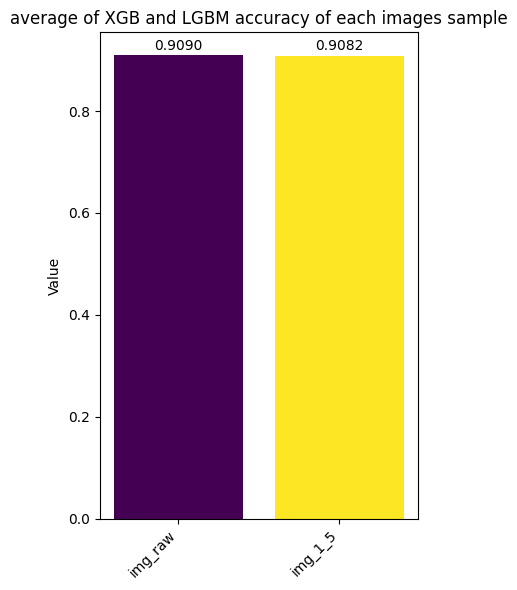

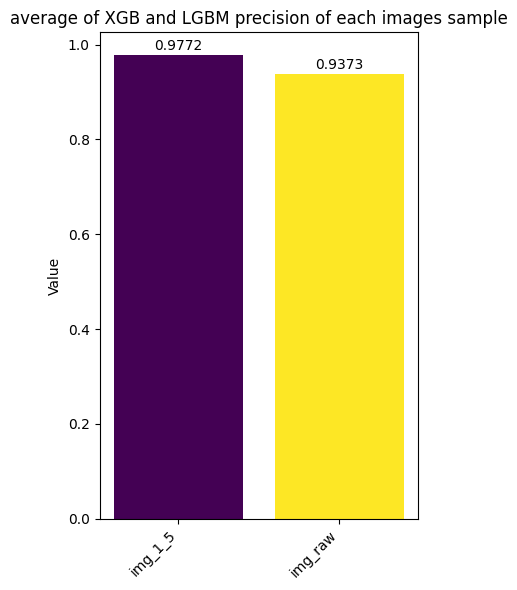

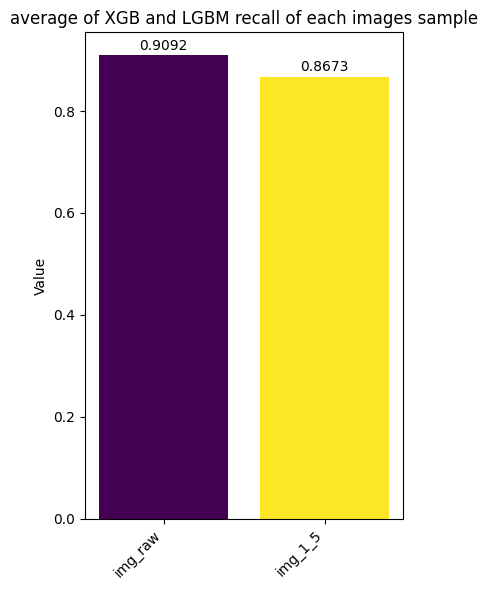

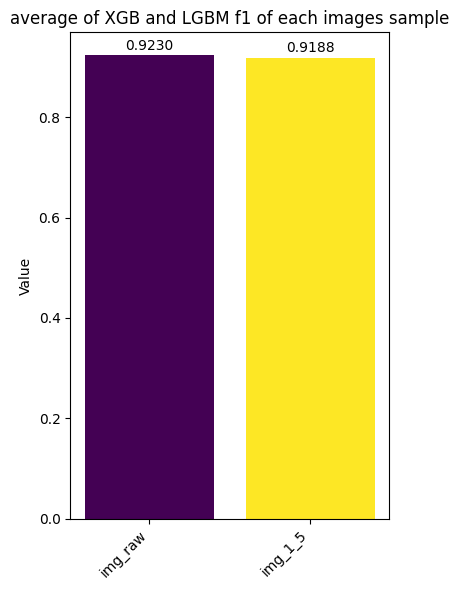

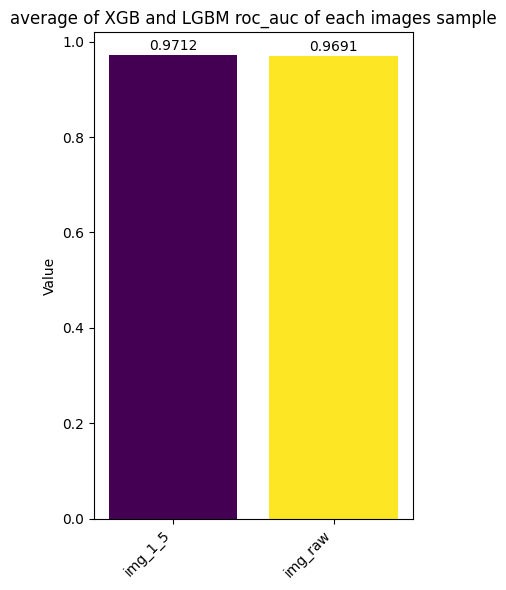

In [67]:
plot_average_results(average_images_results,"images","XGB and LGBM")

In [49]:
average_images_results = {}
for metric,models in results.items():
  average_images_results[metric]={}
  for i in ['img_raw', 'img_1_5']:
    average_images_results[metric][i] = (models["xgb"][i]+models["lgbm"][i]+models["cnn"][i])/3

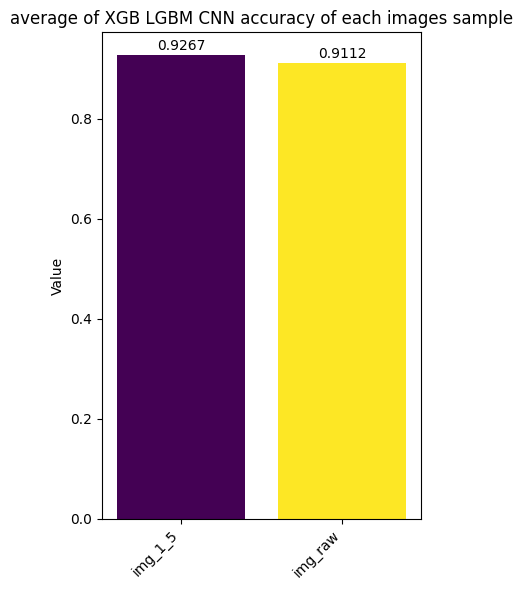

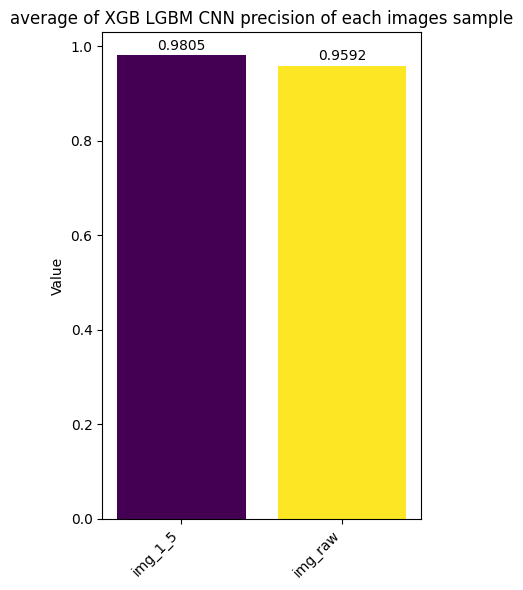

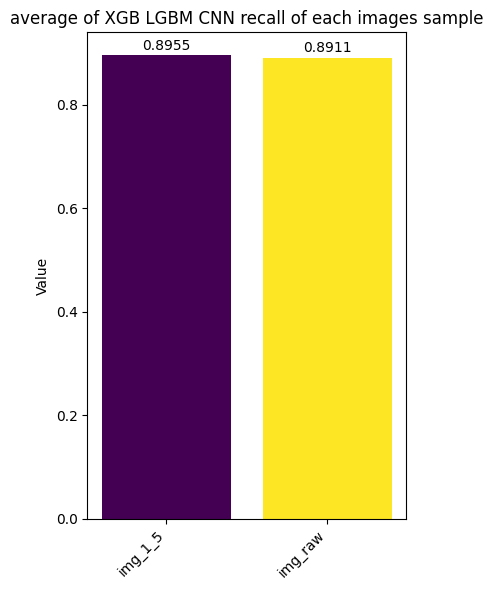

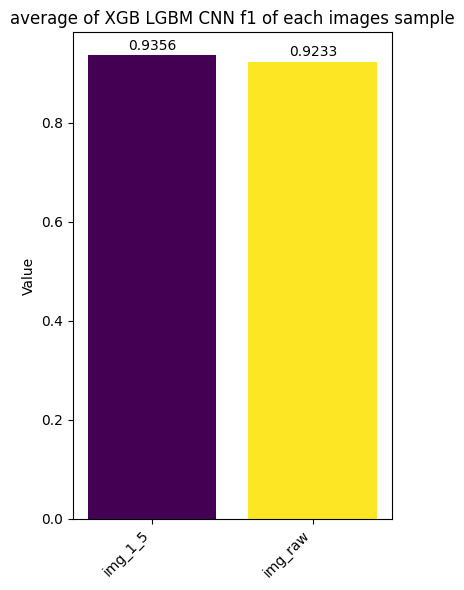

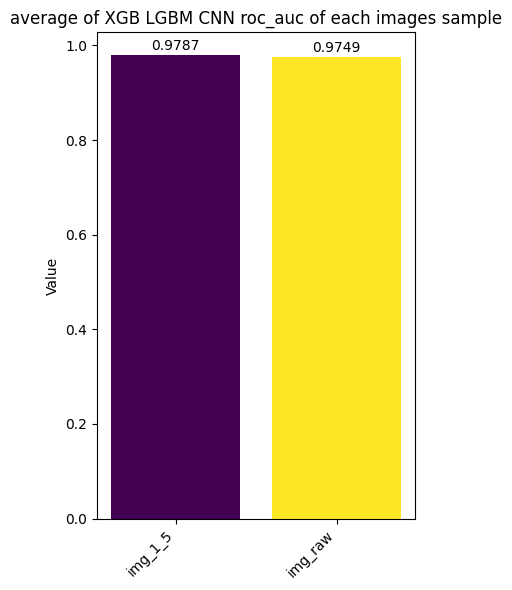

In [50]:
plot_average_results(average_images_results,"images","XGB LGBM CNN")

In [52]:
svm_images_results = {}
for metric,models in results.items():
  svm_images_results[metric]={}
  for i in ['img_raw','img_1_5']:
    svm_images_results[metric][i] = models["svm"][i]

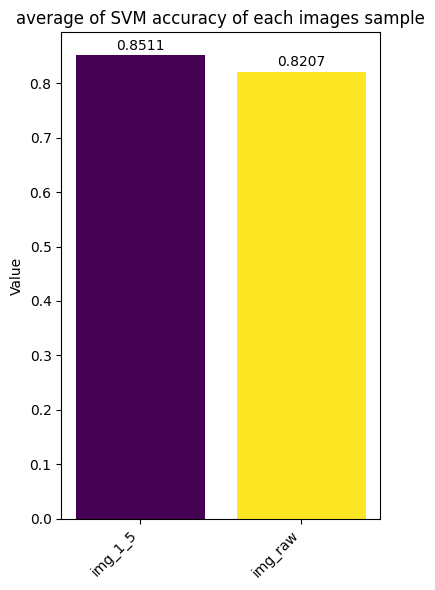

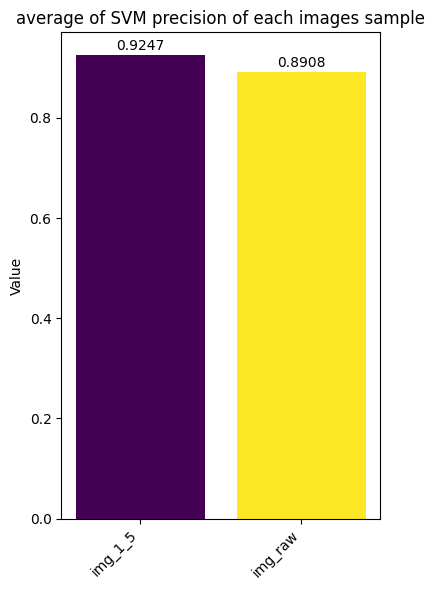

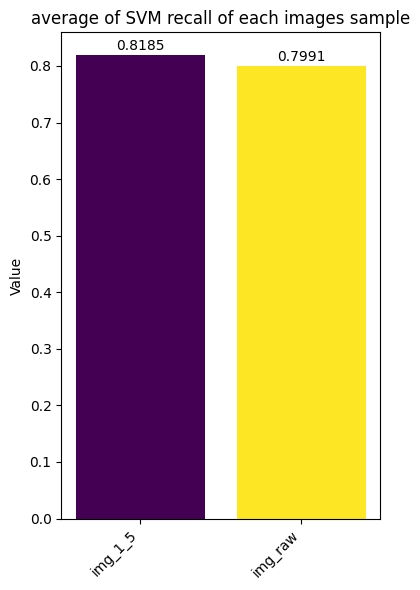

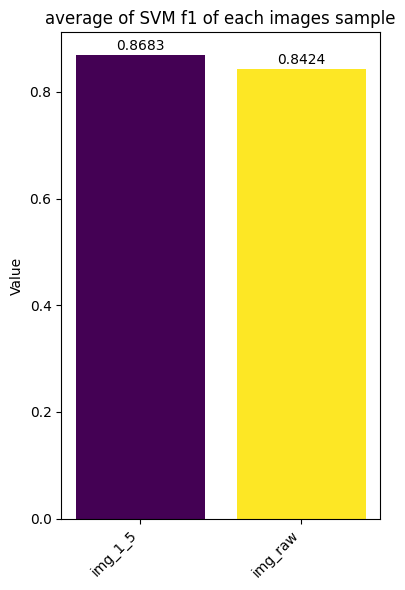

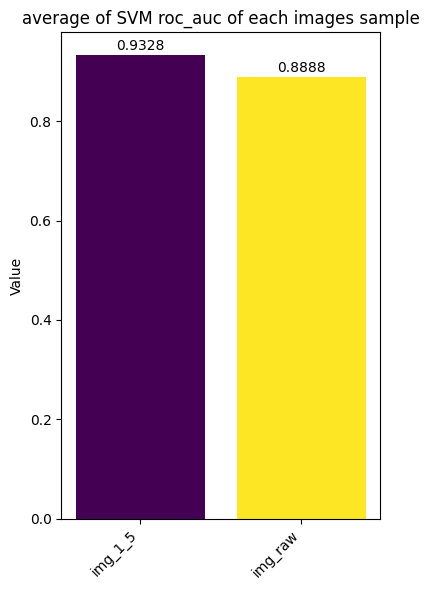

In [53]:
plot_average_results(svm_images_results,"images","SVM")